Model Workflow

# Data Loading &  Processing
## Data source: ccxt for real-time and historical data on OHLCV(open, high, low, closing & volume data) for digital currency (e.g. BTC) using a 1d (daily) timeframe 
Feature Engineering : calculate price, volume & volatility-based indicators 
- Price: Simple Moving Average(SMA), EMA, RSI, MACD (for momentum signals)
--> RSI: measure 
- Volume: OBV (On-Balance Volume), Money Flow Index (MFI)
- Volatility: ATR (Average True Range), Bollinger Bands Width(BBW)



# MODELS:
## 1. XGBoost with feature importances to select <10 features for feature selection 
run 6 xgboost models for close_n_ahead for n = 1 to ... as target variable, to exract predicted values(tnew) as input values for our loss function
- RandomSearch Optimization & 
- BayeasianSearch Optimization 
--> use 3 different optimization techniques: gp_minimize(mathematical), optuna & BayesSearchCV method 

## 2. ARIMA for Time Series - based forecasting
Further Feature engineering: implementing Time Series 
- Add weighted averages based on regression of lagged values, using partial autocorrelation (PACF) to identify autoregressive lags for feature selection
- Implement time-series modelling to forecast short-term price movements using ARIMA, & selecting best ARIMA model based on AIC/BIC criteria to obtain parameters (p - autoregressive order & q - simple moving average order)
Filling missing data with interpolation & normalization


backup model: 
## 3. Linear Regression with PCA for featue selection
- L1 Regularization & 
- L2 Regularization


## Trading Strategy ( based on research paper formula/loss function for calculating weights not provided v hard to obtain weights - suggest a new formula)

Calculate percentage returns and define a treshold to evaluate if price is expected to increase 
--> use log (% return) > x% or <= x% as evaluation criteria (compare against technical indicators?) to buy/sell
--> use own loss function and obtain the best alpha value which returns the best mse (btw tnew and toriginal)
loss function: tnew = w1t1 + w2t2 + ... + w6t6
- WEIGHTS w1, w2,..., w6:
1. Exponential increment
w1 = (1-alpha), w2 = (1-alpha)alpha,..., w6 = (1-alpah)alpha^5
2. Average 
w1 = w2 = ... = w6 = 1/6 alpha



Momentum Oscillators(BUY/SELL SIGNALS)
RSI: 
Purpose: Measures the speed & change of price movements.
Use Case: Buy if RSI < 30 (oversold), Sell if RSI > 70 (overbought)
MACD:
Purpose: Identifies trend reversals via moving average crossovers.
Use Case: Buy if MACD crosses above Signal Line, Sell if MACD crosses below Signal Line
(other indicators we have not considered)
Stochastic Oscillator(STOCH)
Purpose: Identifies overbought & oversold conditions based on recent highs/lows.
Use Case: Buy if %K crosses above %D in oversold zone (<20), Sell if %K crosses below %D in overbought zone (>80)
Rate of Change (ROC)
Purpose: Measures the percentage change of price over a given period.
Use Case: Buy when ROC turns positive, Sell when ROC turns negative.

Volitility Indicators 
Bollinger Bands:
Purpose: Measures price volatility relative to a moving average.
Use Case: Buy when price touches lower band, Sell when price touches upper band.
Average True Range (ATR)
Purpose: Measures market volatility by averaging true range values.
Use Case: High ATR → High volatility, Low ATR → Low volatility.

Volume Indicators 
On-Balance Volume (OBV)
Purpose: Cumulative volume indicator that tracks buying/selling pressure.
Use Case: Rising OBV suggests buying pressure, declining OBV suggests selling pressure.
Money Flow Index (MFI)
Purpose: Volume-weighted RSI to assess buying/selling pressure.
Use Case: Buy if MFI < 20, Sell if MFI > 80


Purpose of a virtual environment: 
Creating a specific location within the file to run/install packages that u need for use within a specific session instead of having them locally. 

In [2]:
#Data Loading
import ccxt
import pandas as pd
import time
from datetime import datetime, timedelta

# Initialize exchange
exchange = ccxt.binance()

# Define symbol and timeframe
symbol = 'BTC/USDT'
timeframe = '1d'

# Calculate timestamp for 1 year ago from Janauary as train data 
end_date = datetime(2025, 1, 1) 
start_date = end_date - timedelta(days=366)  

# Convert to milliseconds (Binance API uses Unix timestamp in milliseconds)
since = int(start_date.timestamp() * 1000)

# Fetch historical OHLCV data
ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since=since)

# Convert to DataFrame
data = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')

# Display the first few rows
print(data.head())
print(data.tail())  # Check the latest date to ensure correct range


   timestamp      open      high       low     close       volume
0 2024-01-01  42283.58  44184.10  42180.77  44179.55  27174.29903
1 2024-01-02  44179.55  45879.63  44148.34  44946.91  65146.40661
2 2024-01-03  44946.91  45500.00  40750.00  42845.23  81194.55173
3 2024-01-04  42845.23  44729.58  42613.77  44151.10  48038.06334
4 2024-01-05  44151.10  44357.46  42450.00  44145.11  48075.25327
     timestamp      open      high       low     close       volume
451 2025-03-27  86909.17  87756.39  85800.00  87232.01  17098.03897
452 2025-03-28  87232.01  87515.67  83585.00  84424.38  27182.73169
453 2025-03-29  84424.38  84624.73  81644.81  82648.54  11696.39864
454 2025-03-30  82648.53  83534.64  81565.00  82389.99   9864.49508
455 2025-03-31  82390.00  83600.00  81278.52  82939.69  13711.30165


In [3]:
from ta.trend import SMAIndicator, EMAIndicator, MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands, AverageTrueRange
from ta.volume import OnBalanceVolumeIndicator, VolumeWeightedAveragePrice, money_flow_index
import numpy as np
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


# Calculate technical indicators
def calculate_technical_indicators(data):
    for n in [5,10,15]:
        data[f'SMA_{n}'] = SMAIndicator(data['close'], window = n).sma_indicator()
    data['EMA_9'] = EMAIndicator(data['close'], window=9).ema_indicator()
    data['RSI'] = RSIIndicator(data['close'], window=14).rsi()
    macd = MACD(data['close'], window_fast=12, window_slow=26, window_sign=9)
    data['MACD'] = macd.macd() 
    # data['MACD_signal'] = macd.macd_signal()
    # data['MACD_hist'] = macd.macd_diff()
    data['OBV'] = OnBalanceVolumeIndicator(data['close'], data['volume']).on_balance_volume()
    data['MFI_10'] = money_flow_index(data['high'], data['low'], data['close'], data['volume'], window=10)
    data['ATR_14'] = AverageTrueRange(data['high'], data['low'], data['close'], window=14).average_true_range()
    bands = BollingerBands(data['close'], window=20, window_dev = 2)
    data['upper_band'] = bands.bollinger_hband()
    # data['middle_band'] = bands.bollinger_mavg()
    data['lower_band'] = bands.bollinger_lband() 
    # data['BBW'] = (data['upper_band'] - data['lower_band']) / data['middle_band']
    data['daily_momentum'] = data['open'] - data['close']
    data['rolling_mean_3'] = data['close'].rolling(window=3).mean()
    data['rolling_std_3'] = data['close'].rolling(window=3).std()
    
    # Lagged Close prices
    data['close_lag_1'] = data['close'].shift(1)
    data['close_lag_2'] = data['close'].shift(2)
    #lead close prices
    for n in [1, 2, 5, 7, 10, 15, 20, 30]:
        data[f'close_{n}_ahead'] = data['close'].shift(-n)
    data['log_return'] = np.log(data['close']).diff()
    data['return_1'] =  (data['close_1_ahead'] - data['close']) / data['close']  
    
    return data 

#handle missing values
def handle_missing_data(data):
    data.ffill(inplace=True)
    data.bfill(inplace = True)
    return data 

btc_data = calculate_technical_indicators(data)
btc_data = handle_missing_data(btc_data)
# btc_data = normalize_data(btc_data)

#inspect data
print(btc_data.head()) 
print(btc_data.tail())


   timestamp      open      high       low     close       volume     SMA_5  \
0 2024-01-01  42283.58  44184.10  42180.77  44179.55  27174.29903  44053.58   
1 2024-01-02  44179.55  45879.63  44148.34  44946.91  65146.40661  44053.58   
2 2024-01-03  44946.91  45500.00  40750.00  42845.23  81194.55173  44053.58   
3 2024-01-04  42845.23  44729.58  42613.77  44151.10  48038.06334  44053.58   
4 2024-01-05  44151.10  44357.46  42450.00  44145.11  48075.25327  44053.58   

      SMA_10        SMA_15         EMA_9  ...  close_1_ahead  close_2_ahead  \
0  44788.027  44272.906667  44912.923399  ...       44946.91       42845.23   
1  44788.027  44272.906667  44912.923399  ...       42845.23       44151.10   
2  44788.027  44272.906667  44912.923399  ...       44151.10       44145.11   
3  44788.027  44272.906667  44912.923399  ...       44145.11       43968.32   
4  44788.027  44272.906667  44912.923399  ...       43968.32       43929.02   

   close_5_ahead  close_7_ahead  close_10_ahead  c

In [428]:
print(btc_data.columns)
print(btc_data.describe())
# check if there are any missing values
print(btc_data.isnull().sum())

Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'SMA_5',
       'SMA_10', 'SMA_15', 'EMA_9', 'RSI', 'MACD', 'OBV', 'MFI_10', 'ATR_14',
       'upper_band', 'lower_band', 'daily_momentum', 'rolling_mean_3',
       'rolling_std_3', 'close_lag_1', 'close_lag_2', 'close_1_ahead',
       'close_2_ahead', 'close_5_ahead', 'close_7_ahead', 'close_10_ahead',
       'close_15_ahead', 'close_20_ahead', 'close_30_ahead', 'log_return',
       'return_1'],
      dtype='object')
                           timestamp           open           high  \
count                            453     453.000000     453.000000   
mean   2024-08-14 00:00:00.000000256   71214.323819   72686.311015   
min              2024-01-01 00:00:00   39568.020000   40176.740000   
25%              2024-04-23 00:00:00   60649.270000   61820.930000   
50%              2024-08-14 00:00:00   66784.680000   67939.400000   
75%              2024-12-05 00:00:00   87232.010000   88967.520000   
max              2025-03-2

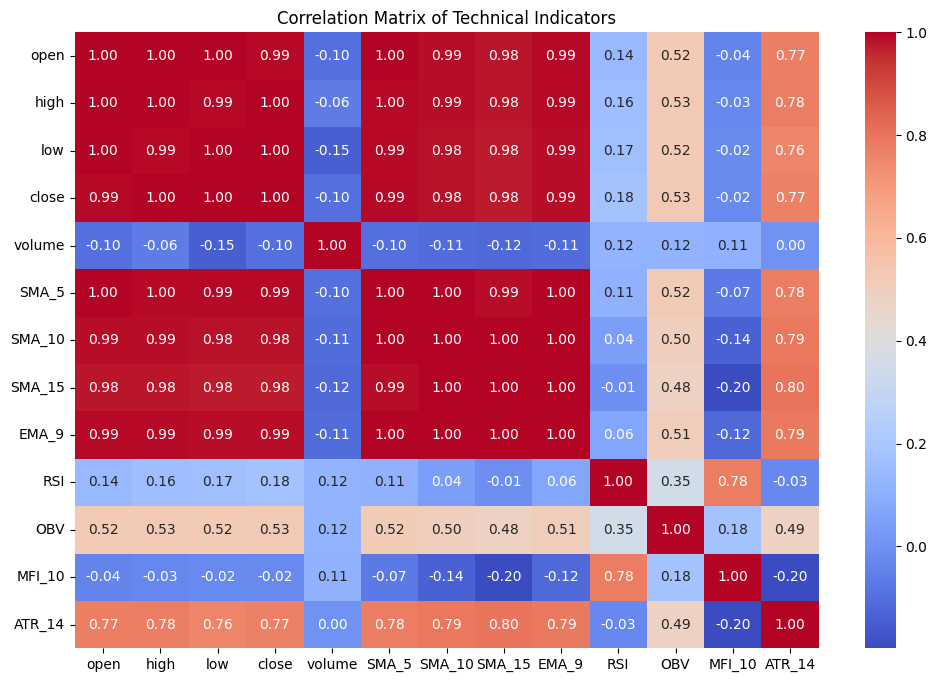

In [429]:
#EDA
import seaborn as sns
import matplotlib.pyplot as plt 

#Distribution of Each Indicaor 
indicators = ['open', 'high', 'low', 'close', 'volume', 'SMA_5','SMA_10', 'SMA_15', 'EMA_9', 'RSI', 'OBV', 'MFI_10', 'ATR_14']  # Select key indicators
def plot_eda():
    # plt.figure(figsize=(12, 6))
    # for i, indicator in enumerate(indicators):
    #     plt.subplot(2, 4, i + 1)
    #     sns.histplot(data[indicator], kde=True, bins=30)
    #     plt.title(indicator)
    # plt.tight_layout()
    # plt.show()

    #Check for Correlations(Feature Redundancy)
    #Some indicators might be highly correlated, making them redundant
    #If correlation > 0.85, remove one of the correlated features.
    # Example: SMA and EMA are usually correlated → Keep only one.
    plt.figure(figsize=(12, 8))
    sns.heatmap(data[indicators].corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Matrix of Technical Indicators")
    plt.show()

    # #Comparing Indicators with closing prices (Plot Trends Over Time)
    # # Check how SMA and EMA interact with price.
    # # Identify points where indicators signal trend reversals.

    # plt.figure(figsize=(12, 6))
    # plt.plot(data.index, data['close'], label='Close Price', color='black')
    # plt.plot(data.index, data['SMA'], label='SMA', linestyle='dashed', color='blue')
    # plt.plot(data.index, data['EMA'], label='EMA', linestyle='dashed', color='red')
    # plt.legend()
    # plt.title("Price with SMA and EMA")
    # plt.show()

    # #Identify Overbought & Oversold Conditions (RSI & MACS)
    # # A. RSI (Relative Strength Index)
    # # RSI > 70 → Overbought (possible sell signal)
    # # RSI < 30 → Oversold (possible buy signal)
    # # Are most RSI values in a normal range (30-70)?
    # # Do RSI peaks align with price reversals?
    # plt.figure(figsize=(12, 6))
    # plt.plot(data.index, data['RSI'], label="RSI", color="purple")
    # plt.axhline(70, linestyle="dashed", color="red", label="Overbought")
    # plt.axhline(30, linestyle="dashed", color="green", label="Oversold")
    # plt.legend()
    # plt.title("RSI Indicator")
    # plt.show()

    # # B. MACD (Moving Average Convergence Divergence)
    # # MACD > Signal Line → Bullish
    # # MACD < Signal Line → Bearish
    # plt.figure(figsize=(12, 6))
    # plt.plot(data.index, data['MACD'], label='MACD', color='blue')
    # plt.plot(data.index, data['MACD_signal'], label='Signal Line', color='red')
    # plt.axhline(0, linestyle="dashed", color="black")
    # plt.legend()
    # plt.title("MACD Indicator")
    # plt.show()

plot_eda()


# XGBoost

In [430]:
print(btc_data.columns)

Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'SMA_5',
       'SMA_10', 'SMA_15', 'EMA_9', 'RSI', 'MACD', 'OBV', 'MFI_10', 'ATR_14',
       'upper_band', 'lower_band', 'daily_momentum', 'rolling_mean_3',
       'rolling_std_3', 'close_lag_1', 'close_lag_2', 'close_1_ahead',
       'close_2_ahead', 'close_5_ahead', 'close_7_ahead', 'close_10_ahead',
       'close_15_ahead', 'close_20_ahead', 'close_30_ahead', 'log_return',
       'return_1'],
      dtype='object')


In [4]:
data = btc_data
# Features and target
features = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'SMA_5',
       'SMA_10', 'SMA_15', 'EMA_9', 'RSI', 'MACD', 'OBV', 'MFI_10', 'ATR_14',
       'upper_band', 'lower_band', 'daily_momentum', 'rolling_mean_3',
       'rolling_std_3', 'close_lag_1', 'close_lag_2']
targets = ['close_1_ahead', 'close_2_ahead', 'close_5_ahead', 'close_7_ahead', 'close_10_ahead', 'close_15_ahead', 'close_20_ahead', 'close_30_ahead', 'return_1']

#define date range correctly
train_end_date = pd.to_datetime('2025-01-01') 
val_end_date = pd.to_datetime('2025-02-28')
test_end_date = pd.to_datetime('2025-03-01')

# Split the data
train_data = data[data['timestamp'] < train_end_date]
val_data = data[(data['timestamp'] >= train_end_date) & (data['timestamp'] <= val_end_date)]
test_data = data[(data['timestamp'] >= val_end_date)]



# Split into X & y 
X_train = train_data[features].drop(columns = ['timestamp'])
X_val = val_data[features].drop(columns = ['timestamp'])
X_test = test_data[features].drop(columns = ['timestamp'])


y_train = train_data[targets]
y_val = val_data[targets]
y_test = test_data[targets]

print(f"X_train size: {X_train.shape}")
print(f"X_val size: {X_val.shape}")
print(f"X_test size: {X_test.shape}")
print(f"y_train size: {y_train.shape}")
print(f"y_val size: {y_val.shape}")
print(f"y_test size: {y_test.shape}")

print(f"Train data: {train_data['timestamp'].min()} to {train_data['timestamp'].max()}")
print(f"Train data: {val_data['timestamp'].min()} to {val_data['timestamp'].max()}")
print(f"Test data: {test_data['timestamp'].min()} to {test_data['timestamp'].max()}")

X_train size: (366, 21)
X_val size: (59, 21)
X_test size: (32, 21)
y_train size: (366, 9)
y_val size: (59, 9)
y_test size: (32, 9)
Train data: 2024-01-01 00:00:00 to 2024-12-31 00:00:00
Train data: 2025-01-01 00:00:00 to 2025-02-28 00:00:00
Test data: 2025-02-28 00:00:00 to 2025-03-31 00:00:00


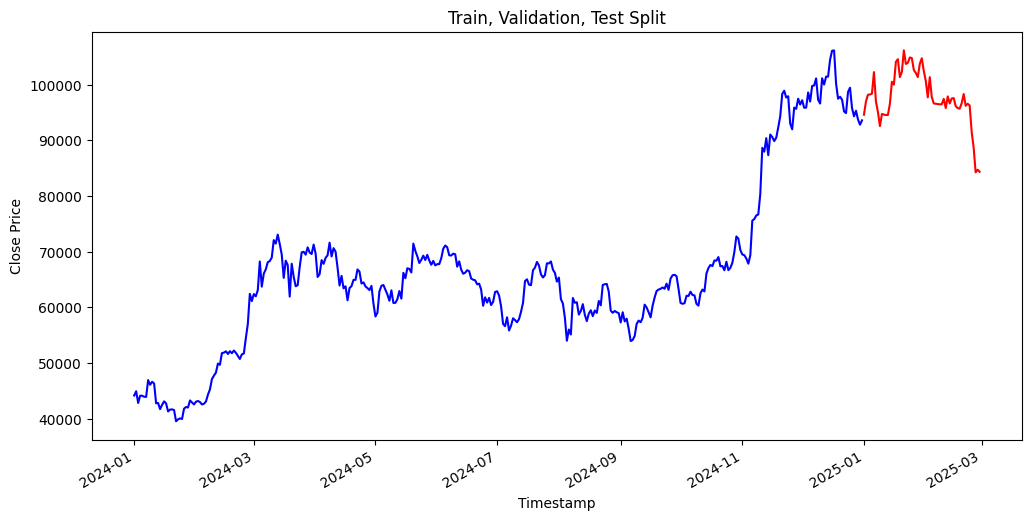

In [431]:
def visualize_train_test_split():
    plt.figure(figsize=(12, 6))
    plt.plot(train_data['timestamp'], train_data['close'], label='Train', color='blue')
    plt.plot(val_data['timestamp'], val_data['close'], label='Validation', color='red')
    plt.title("Train, Validation, Test Split")
    plt.xlabel('Timestamp')
    plt.ylabel('Close Price')
    plt.gcf().autofmt_xdate()  # Rotate date labels for better readability
    plt.show()
visualize_train_test_split()

In [35]:
# Plot BTC price development candlestick chart
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=data['timestamp'], open=data['open'], high=data['high'], low=data['low'], close=data['close'])])
fig.update_layout(title='BTC/USDT Price Development', xaxis_title='Date', yaxis_title='Price')
#theme minimal
fig.update_layout(template='simple_white')
fig.show()


### Hyperparameter Tuning

In [8]:
#all libraries
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from xgboost import XGBRegressor
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, TimeSeriesSplit, PredefinedSplit, GridSearchCV, cross_val_score, ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.feature_selection import VarianceThreshold
from skopt import BayesSearchCV, gp_minimize
from skopt.utils import use_named_args
from skopt.plots import plot_convergence
from skopt.space import Real, Integer
import numpy as np
import matplotlib.pyplot as plt
import optuna


In [19]:
def plot_actual_vs_predicted(train_preds, val_preds, test_preds, 
                           y_train, y_val, y_test, target_var):

    plt.figure(figsize=(20, 10))
    
    # Plot Training Set
    plt.plot(train_data['timestamp'], y_train[target_var], 
             label='Actual (Train)', color='blue', linewidth=2)
    plt.plot(train_data['timestamp'], train_preds, 'g-', 
             label='Predicted (Train)', linewidth=2)
    
    # Plot Validation Set
    plt.plot(val_data['timestamp'], y_val[target_var], 
             label='Actual (Validation)', color='orange', linewidth=2)
    plt.plot(val_data['timestamp'], val_preds, 'y-', 
             label='Predicted (Validation)', linewidth=2)
    
    # Plot Test Set
    plt.plot(test_data['timestamp'], y_test[target_var], 
             label='Actual (Test)', color='red', linewidth=2)
    plt.plot(test_data['timestamp'], test_preds, 'm-', 
             label='Predicted (Test)', linewidth=2)
    
    # Add vertical dividers between periods
    last_train_date = train_end_date
    last_val_date = val_end_date
    
    plt.axvline(x=last_train_date, color='k', linestyle=':', alpha=0.5)
    plt.axvline(x=last_val_date, color='k', linestyle=':', alpha=0.5)
    
    # Formatting
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price', fontsize=12)
    plt.title('Actual vs Predicted Prices', fontsize=14)
    plt.legend(loc='upper left', fontsize=12)
    plt.tight_layout()
    plt.show()



def residual_plot(val_pred, test_pred):
    val_residuals = y_train[targets[0]] - val_pred
    test_residuals = test_data[targets[0]] - test_pred
    # Plot residuals for validation set
    plt.figure(figsize=(12, 6))
    plt.scatter(val_pred, val_residuals, alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title("Residual Plot (Validation Set)")
    plt.xlabel("Predicted Prices")
    plt.ylabel("Residuals (Actual - Predicted)")
    plt.show()

    # Plot residuals for test set
    plt.figure(figsize=(12, 6))
    plt.scatter(test_pred, test_residuals, alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title("Residual Plot (Test Set)")
    plt.xlabel("Predicted Prices")
    plt.ylabel("Residuals (Actual - Predicted)")
    plt.show()
#residual_plot()

# def mse_plot(train_mse, test_mse)
    


Random Search CV

In [14]:
def random_search(target_var):
    # Combine train + val for final training later
    X_train_val = pd.concat([X_train, X_val])
    y_train_val = pd.concat([y_train[target_var], y_val[target_var]])

    # Perform Rolling Expanding Validation  
    tscv = TimeSeriesSplit(n_splits=10)  
    model = XGBRegressor(random_state=42)

    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05],
        'max_depth': [3, 5],
        'min_child_weight': [5, 10],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'gamma': [0, 0.1, 0.2],
        'reg_alpha': [0.1, 1.0],
        'reg_lambda': [1.0, 2.0],
    }

    # Perform Random Search with TimeSeriesSplit cross-validation
    random_search = RandomizedSearchCV(
        model, 
        param_grid, 
        n_iter=50, 
        cv=tscv,  
        n_jobs=-1,
        random_state=42,
        scoring='neg_mean_squared_error'
    )

    print("Running Hyperparameter Tuning...")
    random_search.fit(X_train, y_train[target_var])  
    best_params = random_search.best_params_
    print(f'Best parameters: {best_params}')

    best_model = XGBRegressor(**best_params, random_state=42)
    best_model.fit(X_train, y_train[target_var])

    y_val_pred = best_model.predict(X_val)

    print("\n=== Validation Performance (Jan-Feb 2025) ===")
    print(f"MSE: {mean_squared_error(y_val[target_var], y_val_pred):.4f}")
    print(f"MAE: {mean_absolute_error(y_val[target_var], y_val_pred):.4f}")
    print(f"R²: {r2_score(y_val[target_var], y_val_pred):.4f}")

    # Extract feature importances
    feature_importances = pd.Series(best_model.feature_importances_, index=X_train_val.columns)
    feature_importances_sorted = feature_importances.sort_values(ascending=False)

    # Plot Feature Importance
    feature_importances_sorted[:10].plot(kind='barh', color='skyblue')
    plt.title("Top 10 Feature Importances")
    plt.show()

    # Select features based on importance (top 10)
    selected_features = feature_importances_sorted.head(10).index
    print("Selected Features based on Importance:", selected_features)

    X_train_val_selected = X_train_val[selected_features]

    # Train Final Model with Only Selected Features 
    X_train_selected = X_train[selected_features]
    X_val_selected = X_val[selected_features]
    X_test_selected = X_test[selected_features]

    final_model = XGBRegressor(**best_params, random_state=42)
    final_model.fit(X_train_val_selected, y_train_val)  # Train on selected features

    # Evaluate on Train & Validation
    y_train_pred = final_model.predict(X_train_selected)
    y_val_pred = final_model.predict(X_val_selected)
    # Evaluate on Test Data (March–April 2025) 
    y_test_pred = final_model.predict(X_test_selected)

    print("\n=== Train Performance (Jan-Dec 2024) ===")
    print(f"MSE: {mean_squared_error(y_train[target_var], y_train_pred):.4f}")
    print(f"MAE: {mean_absolute_error(y_train[target_var], y_train_pred):.4f}")
    print(f"R²: {r2_score(y_train[target_var], y_train_pred):.4f}")

    print("\n=== Validation Performance (Jan-Feb 2025) ===")
    print(f"MSE: {mean_squared_error(y_val[target_var], y_val_pred):.4f}")
    print(f"MAE: {mean_absolute_error(y_val[target_var], y_val_pred):.4f}")
    print(f"R²: {r2_score(y_val[target_var], y_val_pred):.4f}")


    print("\n=== Test Performance (March-April 2025) ===")
    print(f"MSE: {mean_squared_error(y_test[target_var], y_test_pred):.4f}")
    print(f"MAE: {mean_absolute_error(y_test[target_var], y_test_pred):.4f}")
    print(f"R²: {r2_score(y_test[target_var], y_test_pred):.4f}")

    return final_model, y_train_pred, y_val_pred, y_test_pred



Running Hyperparameter Tuning...
Best parameters: {'subsample': 0.8, 'reg_lambda': 1.0, 'reg_alpha': 1.0, 'n_estimators': 200, 'min_child_weight': 10, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.6}

=== Validation Performance (Jan-Feb 2025) ===
MSE: 8775228.5699
MAE: 2384.0745
R²: 0.6492


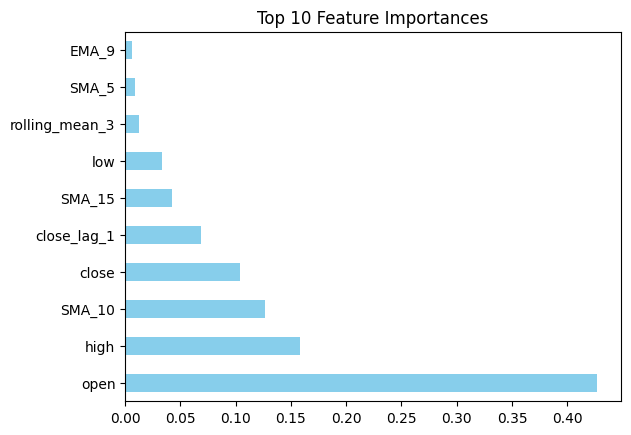

Selected Features based on Importance: Index(['open', 'high', 'SMA_10', 'close', 'close_lag_1', 'SMA_15', 'low',
       'rolling_mean_3', 'SMA_5', 'EMA_9'],
      dtype='object')

=== Train Performance (Jan-Dec 2024) ===
MSE: 1632244.8552
MAE: 954.5110
R²: 0.9924

=== Validation Performance (Jan-Feb 2025) ===
MSE: 1626126.3687
MAE: 988.6768
R²: 0.9350

=== Test Performance (March-April 2025) ===
MSE: 11031853.4442
MAE: 2596.9659
R²: -0.1711


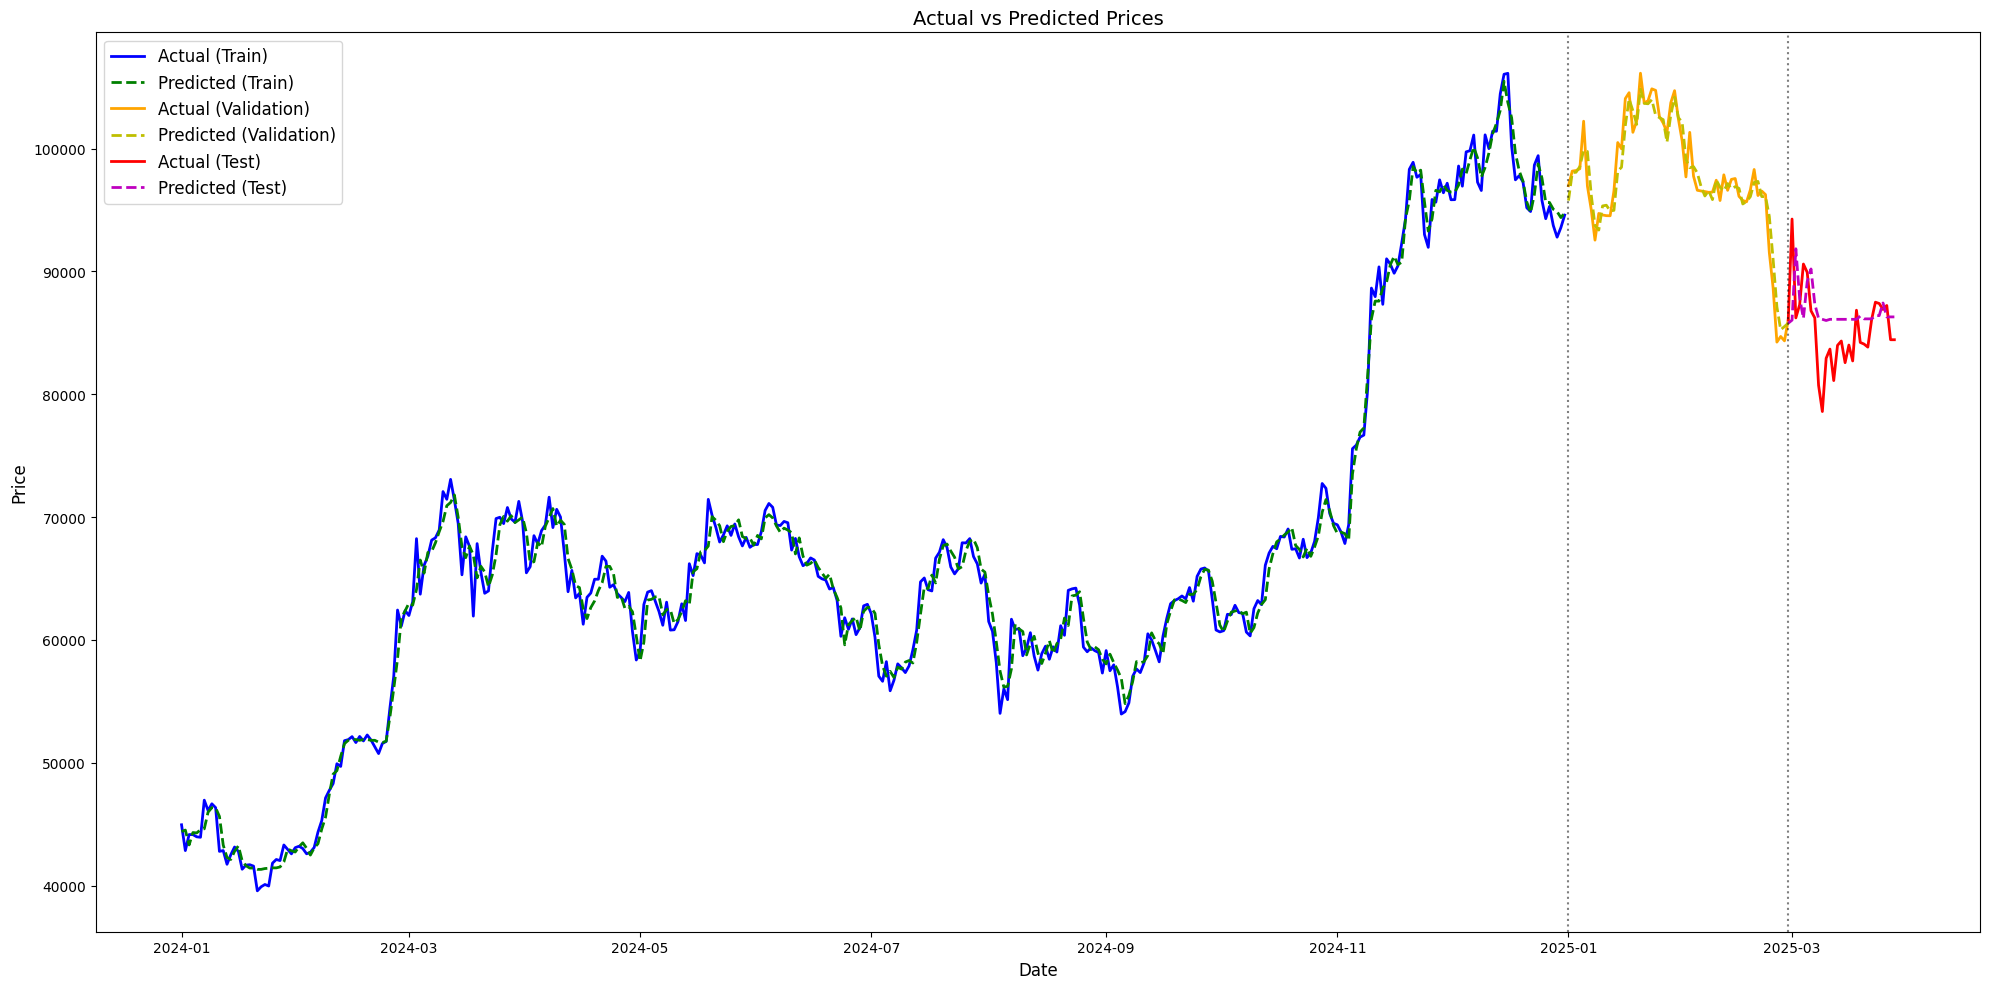

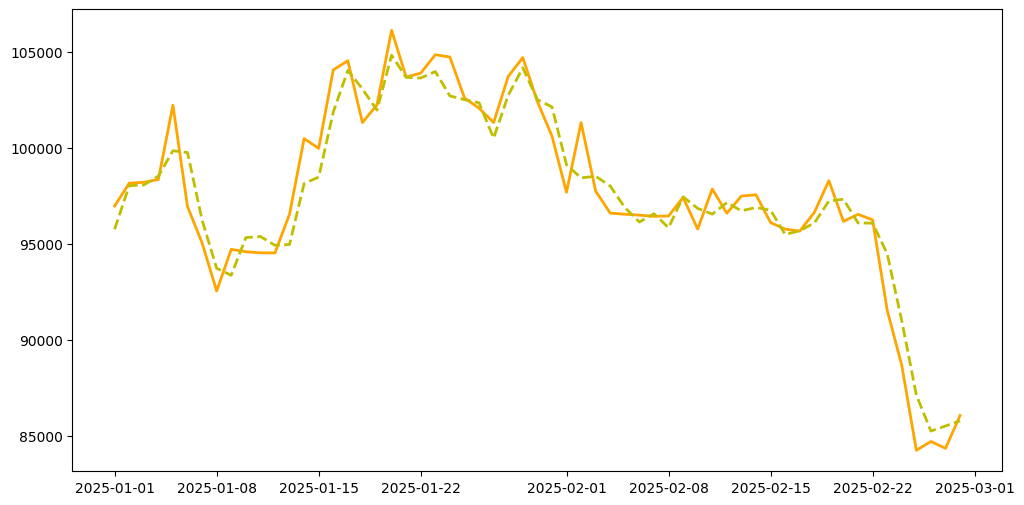

In [534]:
rs_xgboost_model_1, train_predictions_rs_1, val_predictions_rs_1, test_predictions_rs_1 = random_search('close_1_ahead')
plot_actual_vs_predicted(
    train_predictions_rs_1, 
    val_predictions_rs_1, 
    test_predictions_rs_1 ,
    y_train,
    y_val,
    y_test, 
    'close_1_ahead'
)

# Plot Validation Set
plt.figure(figsize=(12,6))
plt.plot(val_data['timestamp'], y_val['close_1_ahead'], 
            label='Actual (Validation)', color='orange', linewidth=2)
plt.plot(val_data['timestamp'], val_predictions_rs_1, 'y--', 
            label='Predicted (Validation)', linewidth=2)
plt.show()
    

Running Hyperparameter Tuning...
Best parameters: {'subsample': 0.8, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'n_estimators': 200, 'min_child_weight': 10, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.6}

=== Validation Performance (Jan-Feb 2025) ===
MSE: 0.0005
MAE: 0.0167
R²: -0.0328


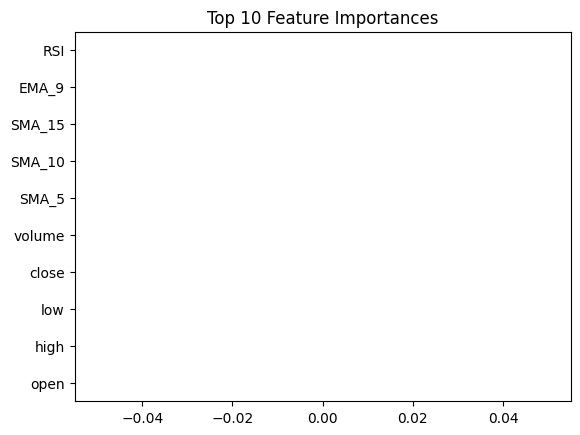

Selected Features based on Importance: Index(['open', 'high', 'low', 'close', 'volume', 'SMA_5', 'SMA_10', 'SMA_15',
       'EMA_9', 'RSI'],
      dtype='object')

=== Train Performance (Jan-Dec 2024) ===
MSE: 0.0008
MAE: 0.0200
R²: -0.0003

=== Validation Performance (Jan-Feb 2025) ===
MSE: 0.0005
MAE: 0.0165
R²: -0.0240

=== Test Performance (March-April 2025) ===
MSE: 0.0012
MAE: 0.0247
R²: -0.0026


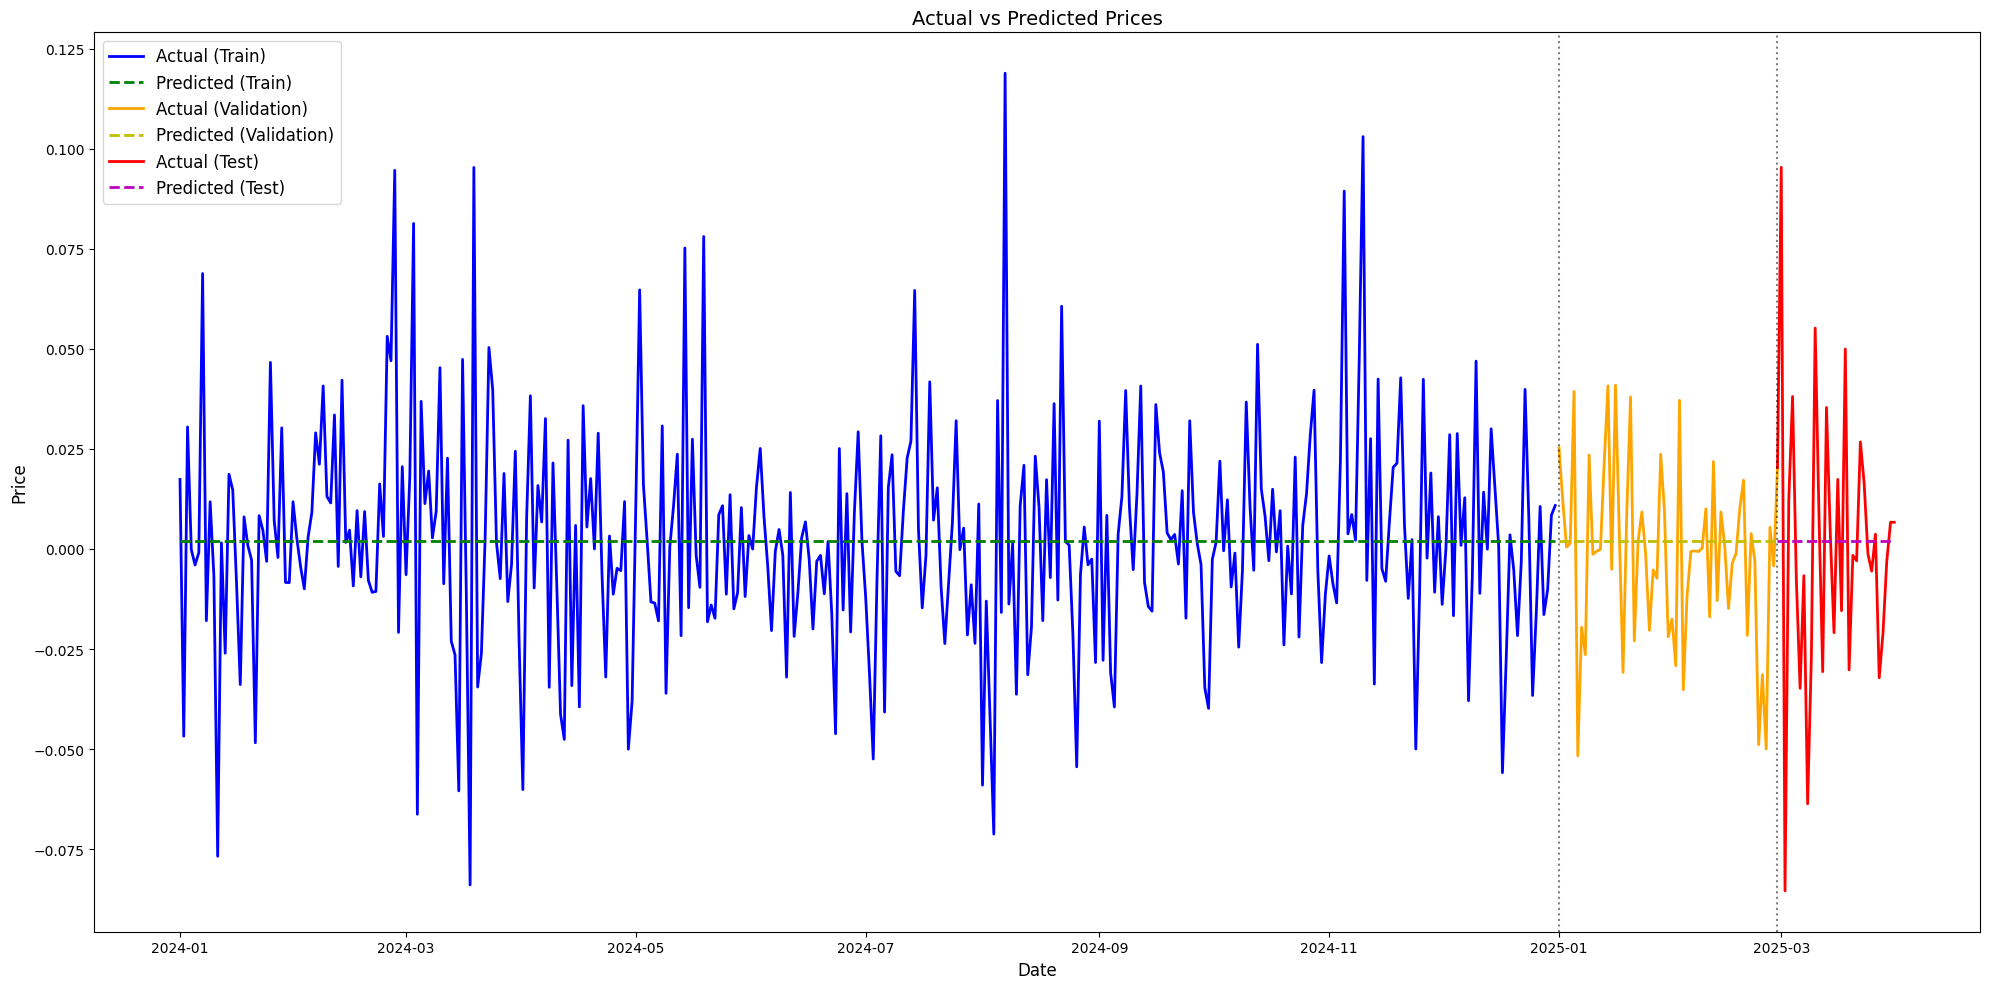

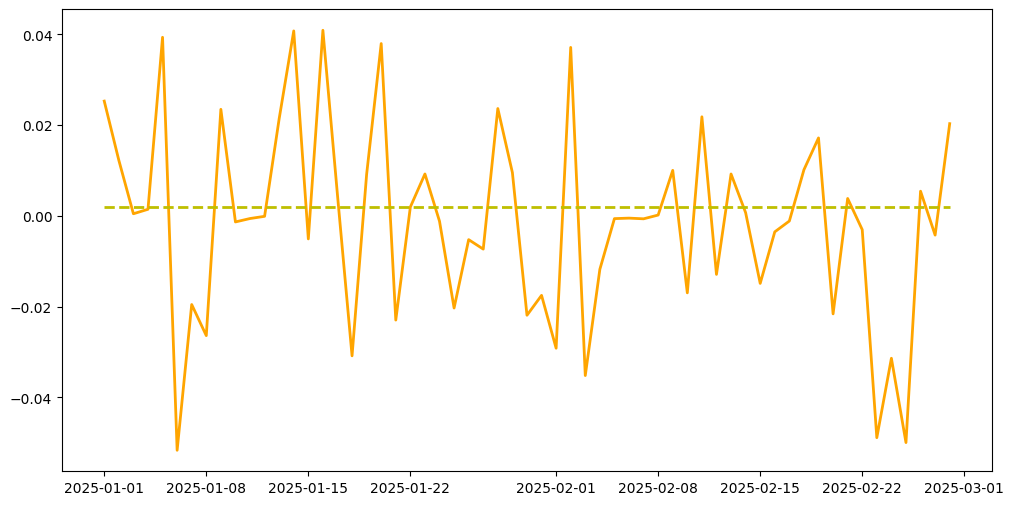

In [15]:
rs_xgboost_model_1, train_predictions_rs_1, val_predictions_rs_1, test_predictions_rs_1 = random_search('return_1')
plot_actual_vs_predicted(
    train_predictions_rs_1, 
    val_predictions_rs_1, 
    test_predictions_rs_1 ,
    y_train,
    y_val,
    y_test, 
    'return_1'
)

# Plot Validation Set
plt.figure(figsize=(12,6))
plt.plot(val_data['timestamp'], y_val['return_1'], 
            label='Actual (Validation)', color='orange', linewidth=2)
plt.plot(val_data['timestamp'], val_predictions_rs_1, 'y--', 
            label='Predicted (Validation)', linewidth=2)
plt.show()

In [16]:
print(train_predictions_rs_1)
val_predictions_rs_1, 
test_predictions_rs_1

[0.00198353 0.00198353 0.00198353 0.00198353 0.00198353 0.00198353
 0.00198353 0.00198353 0.00198353 0.00198353 0.00198353 0.00198353
 0.00198353 0.00198353 0.00198353 0.00198353 0.00198353 0.00198353
 0.00198353 0.00198353 0.00198353 0.00198353 0.00198353 0.00198353
 0.00198353 0.00198353 0.00198353 0.00198353 0.00198353 0.00198353
 0.00198353 0.00198353 0.00198353 0.00198353 0.00198353 0.00198353
 0.00198353 0.00198353 0.00198353 0.00198353 0.00198353 0.00198353
 0.00198353 0.00198353 0.00198353 0.00198353 0.00198353 0.00198353
 0.00198353 0.00198353 0.00198353 0.00198353 0.00198353 0.00198353
 0.00198353 0.00198353 0.00198353 0.00198353 0.00198353 0.00198353
 0.00198353 0.00198353 0.00198353 0.00198353 0.00198353 0.00198353
 0.00198353 0.00198353 0.00198353 0.00198353 0.00198353 0.00198353
 0.00198353 0.00198353 0.00198353 0.00198353 0.00198353 0.00198353
 0.00198353 0.00198353 0.00198353 0.00198353 0.00198353 0.00198353
 0.00198353 0.00198353 0.00198353 0.00198353 0.00198353 0.0019

array([0.00198353, 0.00198353, 0.00198353, 0.00198353, 0.00198353,
       0.00198353, 0.00198353, 0.00198353, 0.00198353, 0.00198353,
       0.00198353, 0.00198353, 0.00198353, 0.00198353, 0.00198353,
       0.00198353, 0.00198353, 0.00198353, 0.00198353, 0.00198353,
       0.00198353, 0.00198353, 0.00198353, 0.00198353, 0.00198353,
       0.00198353, 0.00198353, 0.00198353, 0.00198353, 0.00198353,
       0.00198353, 0.00198353], dtype=float32)

Bayesian Optimization

In [536]:
def bayes_xg_boost(target_var):

    print("=== Phase 1: Feature Selection ===")
    
    # A. Remove low-variance features
    variance_selector = VarianceThreshold(threshold=0.01)
    X_train_filtered = variance_selector.fit_transform(X_train)
    
    
    # # Get remaining feature names
    remaining_features = X_train.columns[variance_selector.get_support()]
    print(remaining_features)
    print(f"Removed {X_train.shape[1] - len(remaining_features)} low-variance features")

    # #B: Feature Correlation Analysis - removes almost all SMA & EMA features
    # corr_matrix = pd.DataFrame(X_train_filtered, columns=remaining_features).corr().abs()
    # upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    # to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]  # 0.8 threshold
    # print(to_drop)
    # X_train_filtered = pd.DataFrame(X_train_filtered, columns=remaining_features).drop(to_drop, axis=1)

    # Define the initial model
    initial_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
    initial_model.fit(X_train[remaining_features], y_train[target_var])
        
    # C: Get feature importances & select top 10
    feature_importances = pd.Series(initial_model.feature_importances_, index=remaining_features)
    feature_importances = feature_importances.sort_values(ascending=False)
    
    print(f'Feature importances:\n{feature_importances}')
    feature_importances[:10].plot(kind='barh', color='skyblue')
    plt.title("Top 10 Feature Importances")
    plt.show()

    selected_features = feature_importances.nlargest(10).index.tolist()
    print(f"\nSelected {len(selected_features)} features:\n{selected_features}")

    # Create train/val/test sets with selected features
    X_train_selected = X_train[selected_features]
    X_val_selected = X_val[selected_features]
    X_test_selected = X_test[selected_features]

    print("\n=== Phase 2: Hyperparameter Optimization ===")
    tscv = TimeSeriesSplit(n_splits=5)
    model = XGBRegressor(objective='reg:squarederror', random_state=42)

    # Define the search space for hyperparameters 
    search_space = {
        'learning_rate': Real(0.01, 0.7, prior='log-uniform'), 
        'max_depth': Integer(5, 14), 
        'gamma': Real(0.4, 6.4), 
        'reg_alpha': Real(0.4, 6.4), 
        'reg_lambda': Real(0.4, 6.4), 
        'n_estimators': Integer(50, 200)
    }

    # Step 1: Optimize hyperparameters using BayesSearchCV
    opt = BayesSearchCV(
        model,
        search_space,
        cv=tscv,
        n_jobs=-1,
        scoring='neg_mean_squared_error',
        random_state=42
    )

    opt.fit(X_train_selected, y_train[target_var])

    # Best parameters from BayesSearchCV
    best_params_bayescv = opt.best_params_
    y_test_predcv = opt.predict(X_val_selected)
    mse_bayescv = mean_squared_error(y_val[target_var], y_test_predcv)
    print(f"Prediction MSE (BayesSearchCV): {mse_bayescv}")

    # Step 2: Optimize hyperparameters using Optuna
    def objective_optuna(trial):
        params = {
            'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.1, log=True),
            'max_depth': trial.suggest_int('max_depth', 5, 7),
            'gamma': trial.suggest_float('gamma', 0, 1.6),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.4, 6.4),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.4, 6.4), 
            'n_estimators': trial.suggest_int('n_estimators', 50, 200)
        }
        model = XGBRegressor(**params, objective='reg:squarederror', random_state=42)
        scores = cross_val_score(model, X_train_selected, y_train[target_var], cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
        return -np.mean(scores)

    study = optuna.create_study(direction='minimize')
    study.optimize(objective_optuna, n_trials=25)

    best_params_optuna = study.best_params
    model_optuna = XGBRegressor(**best_params_optuna, objective='reg:squarederror', random_state=42)
    model_optuna.fit(X_train_selected, y_train[target_var])
    test_prediction_optuna = model_optuna.predict(X_val_selected)
    mse_optuna = mean_squared_error(y_val[target_var], test_prediction_optuna)
    print(f"Prediction MSE (Optuna): {mse_optuna}")

    # Step 3: Compare results and select the best model
    results = {
        'BayesSearchCV': {'params': best_params_bayescv, 'mse': mse_bayescv},
        'Optuna': {'params': best_params_optuna, 'mse': mse_optuna}
    }

    best_method = min(results, key=lambda k: results[k]['mse'])
    best_params_final = results[best_method]['params']
    print(f"Best method: {best_method}")
    print(f"Best parameters: {best_params_final}")

    # Step 4: Train the final model with best params on all available data
    final_model = XGBRegressor(**best_params_final, objective='reg:squarederror', random_state=42)
    X_train_val_selected = pd.concat([X_train_selected, X_val_selected])
    y_train_val = pd.concat([y_train, y_val])
    final_model.fit(X_train_val_selected, y_train_val[target_var])

    # Evaluate model on train, val, and test sets
    y_train_pred = final_model.predict(X_train_selected)
    y_val_pred = final_model.predict(X_val_selected)
    y_test_pred = final_model.predict(X_test_selected)

    print("\n=== Train Performance ===")
    print(f"MSE: {mean_squared_error(y_train[target_var], y_train_pred):.4f}")
    print(f"MAE: {mean_absolute_error(y_train[target_var], y_train_pred):.4f}")
    print(f"R²: {r2_score(y_train[target_var], y_train_pred):.4f}")

    print("\n=== Validation Performance ===")
    print(f"MSE: {mean_squared_error(y_val[target_var], y_val_pred):.4f}")
    print(f"MAE: {mean_absolute_error(y_val[target_var], y_val_pred):.4f}")
    print(f"R²: {r2_score(y_val[target_var], y_val_pred):.4f}")

    print("\n=== Test Performance ===")
    print(f"MSE: {mean_squared_error(y_test[target_var], y_test_pred):.4f}")
    print(f"MAE: {mean_absolute_error(y_test[target_var], y_test_pred):.4f}")
    print(f"R²: {r2_score(y_test[target_var], y_test_pred):.4f}")

    return final_model, best_params_final, y_train_pred, y_val_pred, y_test_pred

=== Phase 1: Feature Selection ===
Index(['open', 'high', 'low', 'close', 'volume', 'SMA_5', 'SMA_10', 'SMA_15',
       'EMA_9', 'RSI', 'MACD', 'OBV', 'MFI_10', 'ATR_14', 'upper_band',
       'lower_band', 'daily_momentum', 'rolling_mean_3', 'rolling_std_3',
       'close_lag_1', 'close_lag_2'],
      dtype='object')
Removed 0 low-variance features
Feature importances:
close             0.376984
open              0.323589
SMA_10            0.151338
SMA_15            0.065753
high              0.056762
low               0.008072
close_lag_2       0.003709
rolling_mean_3    0.002624
upper_band        0.002280
SMA_5             0.001148
daily_momentum    0.001110
MACD              0.001043
OBV               0.001019
rolling_std_3     0.000841
RSI               0.000737
volume            0.000697
EMA_9             0.000611
MFI_10            0.000580
ATR_14            0.000579
lower_band        0.000418
close_lag_1       0.000107
dtype: float32


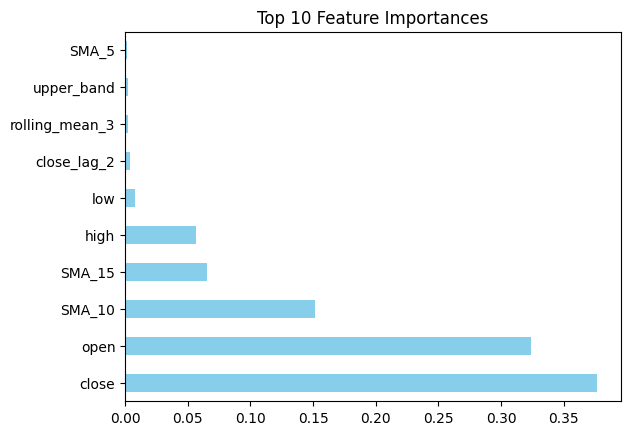


Selected 10 features:
['close', 'open', 'SMA_10', 'SMA_15', 'high', 'low', 'close_lag_2', 'rolling_mean_3', 'upper_band', 'SMA_5']

=== Phase 2: Hyperparameter Optimization ===


[I 2025-03-31 21:06:23,018] A new study created in memory with name: no-name-05ac714a-0c8c-4f8a-9cda-084d7947d347


Prediction MSE (BayesSearchCV): 10707985.850307817


[I 2025-03-31 21:06:23,478] Trial 0 finished with value: 182335608.61164942 and parameters: {'learning_rate': 0.06551584637296305, 'max_depth': 7, 'gamma': 1.1464511199365859, 'reg_alpha': 4.290587837881829, 'reg_lambda': 5.877973131622375, 'n_estimators': 175}. Best is trial 0 with value: 182335608.61164942.
[I 2025-03-31 21:06:23,767] Trial 1 finished with value: 191114483.51184034 and parameters: {'learning_rate': 0.08721285541993086, 'max_depth': 6, 'gamma': 0.5488748525327626, 'reg_alpha': 5.222285085534617, 'reg_lambda': 3.2481038819595436, 'n_estimators': 130}. Best is trial 0 with value: 182335608.61164942.
[I 2025-03-31 21:06:24,097] Trial 2 finished with value: 193266624.38975495 and parameters: {'learning_rate': 0.053439016833726094, 'max_depth': 7, 'gamma': 0.5888602443317487, 'reg_alpha': 5.327987292787954, 'reg_lambda': 4.61834069113866, 'n_estimators': 101}. Best is trial 0 with value: 182335608.61164942.
[I 2025-03-31 21:06:24,322] Trial 3 finished with value: 195929983

Prediction MSE (Optuna): 11140405.614315199
Best method: BayesSearchCV
Best parameters: OrderedDict([('gamma', 4.850303529995089), ('learning_rate', 0.7), ('max_depth', 10), ('n_estimators', 200), ('reg_alpha', 0.4), ('reg_lambda', 0.4)])

=== Train Performance ===
MSE: 4.1501
MAE: 1.3686
R²: 1.0000

=== Validation Performance ===
MSE: 2.2016
MAE: 1.0532
R²: 1.0000

=== Test Performance ===
MSE: 12462444.5474
MAE: 2788.4346
R²: -0.3229


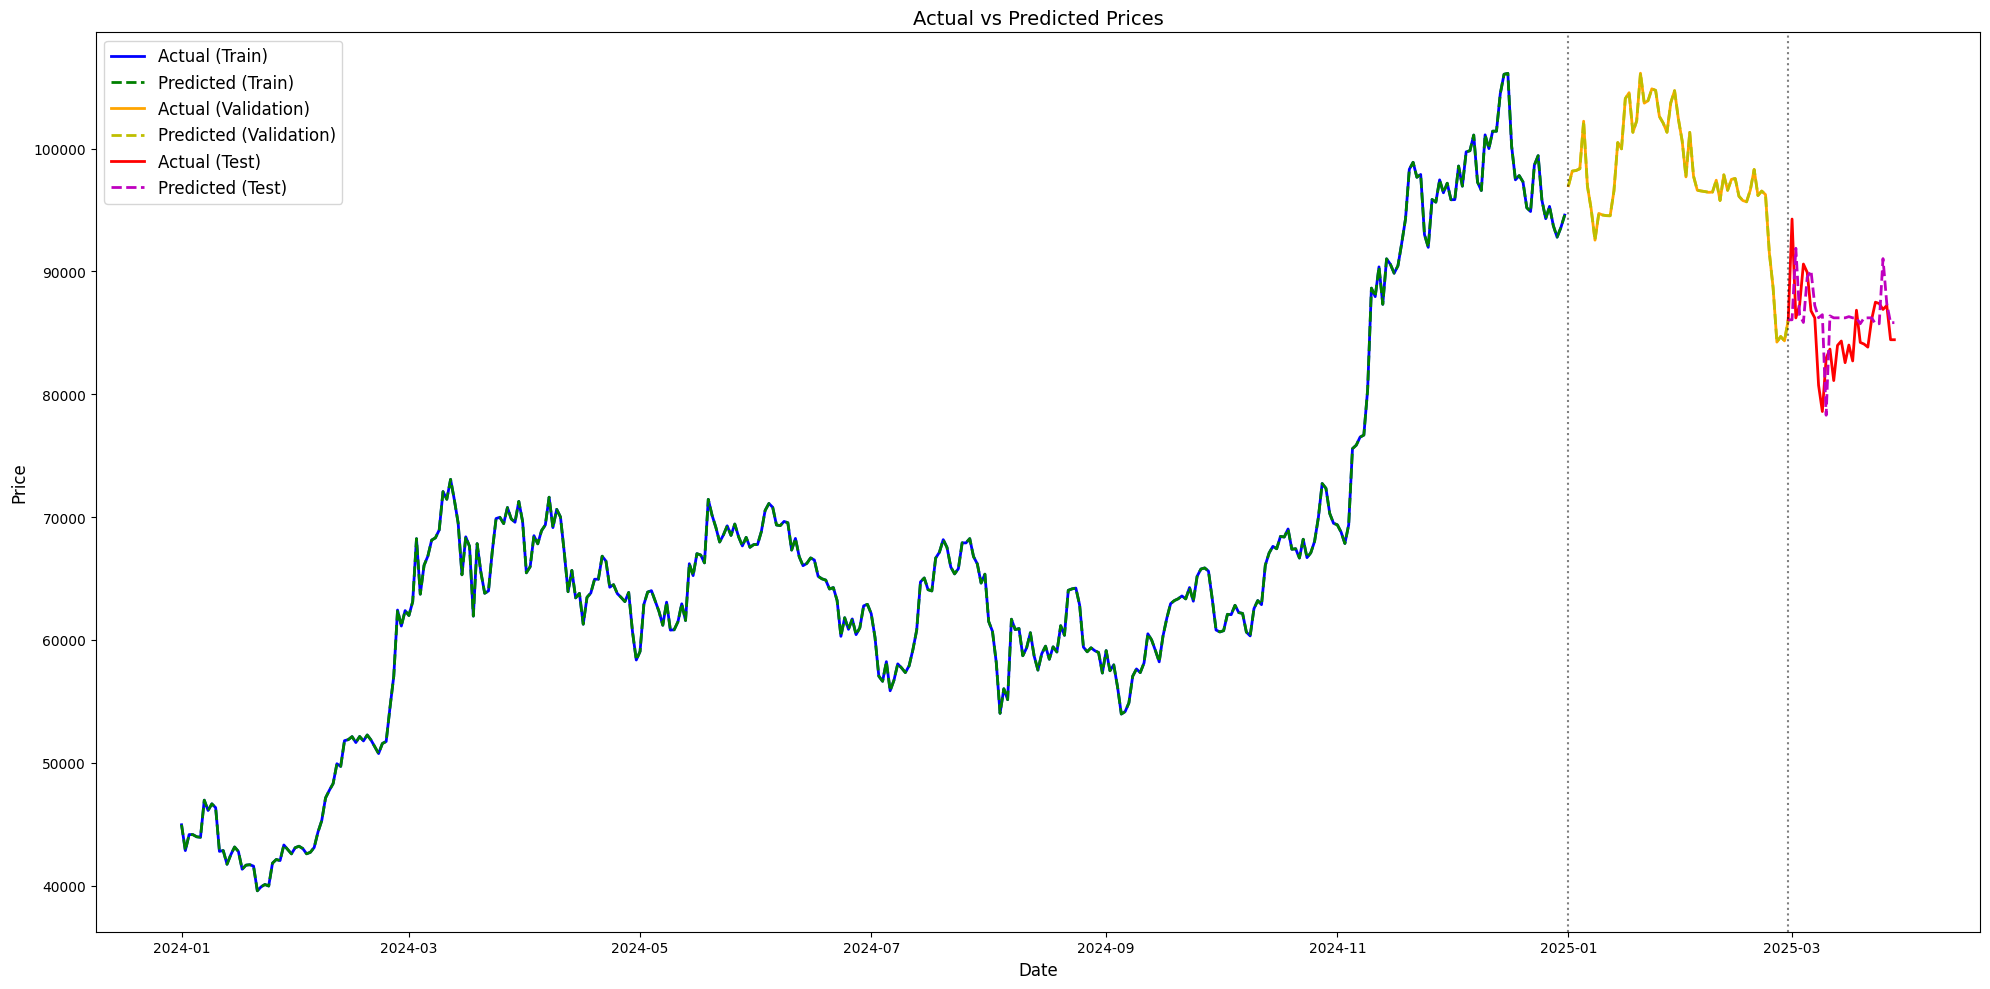

In [537]:
bayes_xg_boost_1_model, bayes_xg_boost_1_params, train_prediction_bayes, val_prediction_bayes, test_prediction_bayes = bayes_xg_boost('close_1_ahead')
plot_actual_vs_predicted(
    train_prediction_bayes,
    val_prediction_bayes,
    test_prediction_bayes,
    y_train,
    y_val,
    y_test, 
    'close_1_ahead'
)

=== Phase 1: Feature Selection ===
Index(['open', 'high', 'low', 'close', 'volume', 'SMA_5', 'SMA_10', 'SMA_15',
       'EMA_9', 'RSI', 'MACD', 'OBV', 'MFI_10', 'ATR_14', 'upper_band',
       'lower_band', 'daily_momentum', 'rolling_mean_3', 'rolling_std_3',
       'close_lag_1', 'close_lag_2'],
      dtype='object')
Removed 0 low-variance features
Feature importances:
SMA_15            2.925070e-01
open              2.299234e-01
high              1.876298e-01
close             1.458968e-01
SMA_10            9.067754e-02
low               1.373974e-02
rolling_mean_3    1.037324e-02
SMA_5             5.623764e-03
upper_band        4.370606e-03
EMA_9             3.374666e-03
OBV               2.895297e-03
close_lag_2       2.740767e-03
RSI               2.415203e-03
ATR_14            1.899297e-03
lower_band        1.414167e-03
rolling_std_3     1.162200e-03
MACD              1.058105e-03
MFI_10            8.840932e-04
daily_momentum    7.202039e-04
volume            6.935276e-04
close_la

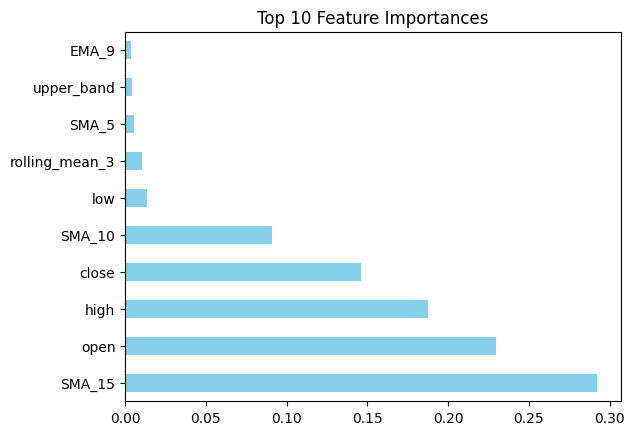


Selected 10 features:
['SMA_15', 'open', 'high', 'close', 'SMA_10', 'low', 'rolling_mean_3', 'SMA_5', 'upper_band', 'EMA_9']

=== Phase 2: Hyperparameter Optimization ===


[I 2025-03-31 17:11:15,363] A new study created in memory with name: no-name-d1032343-4731-48d0-9fe3-27ec014b2f3a


Prediction MSE (BayesSearchCV): 20029993.08911979


[I 2025-03-31 17:11:15,680] Trial 0 finished with value: 198084989.23291284 and parameters: {'learning_rate': 0.06835577392490835, 'max_depth': 6, 'gamma': 0.6804932509805879, 'reg_alpha': 3.780037963525272, 'reg_lambda': 1.6941355690699034, 'n_estimators': 75}. Best is trial 0 with value: 198084989.23291284.
[I 2025-03-31 17:11:16,027] Trial 1 finished with value: 219266382.2217998 and parameters: {'learning_rate': 0.06341586873672059, 'max_depth': 5, 'gamma': 0.7184717835695512, 'reg_alpha': 0.9001356911871853, 'reg_lambda': 5.945003335248408, 'n_estimators': 156}. Best is trial 0 with value: 198084989.23291284.
[I 2025-03-31 17:11:16,466] Trial 2 finished with value: 203896352.79349622 and parameters: {'learning_rate': 0.09575929904340948, 'max_depth': 6, 'gamma': 1.4658159359394254, 'reg_alpha': 3.1837619477648205, 'reg_lambda': 2.452422360117733, 'n_estimators': 127}. Best is trial 0 with value: 198084989.23291284.
[I 2025-03-31 17:11:17,191] Trial 3 finished with value: 222729765

Prediction MSE (Optuna): 20255617.00512441
Best method: BayesSearchCV
Best parameters: OrderedDict([('gamma', 0.4), ('learning_rate', 0.13061816231191736), ('max_depth', 14), ('n_estimators', 168), ('reg_alpha', 0.4), ('reg_lambda', 0.4)])

=== Train Performance ===
MSE: 0.2127
MAE: 0.3264
R²: 1.0000

=== Validation Performance ===
MSE: 0.2787
MAE: 0.3998
R²: 1.0000

=== Test Performance ===
MSE: 38764342.0052
MAE: 5545.8760
R²: -3.1117


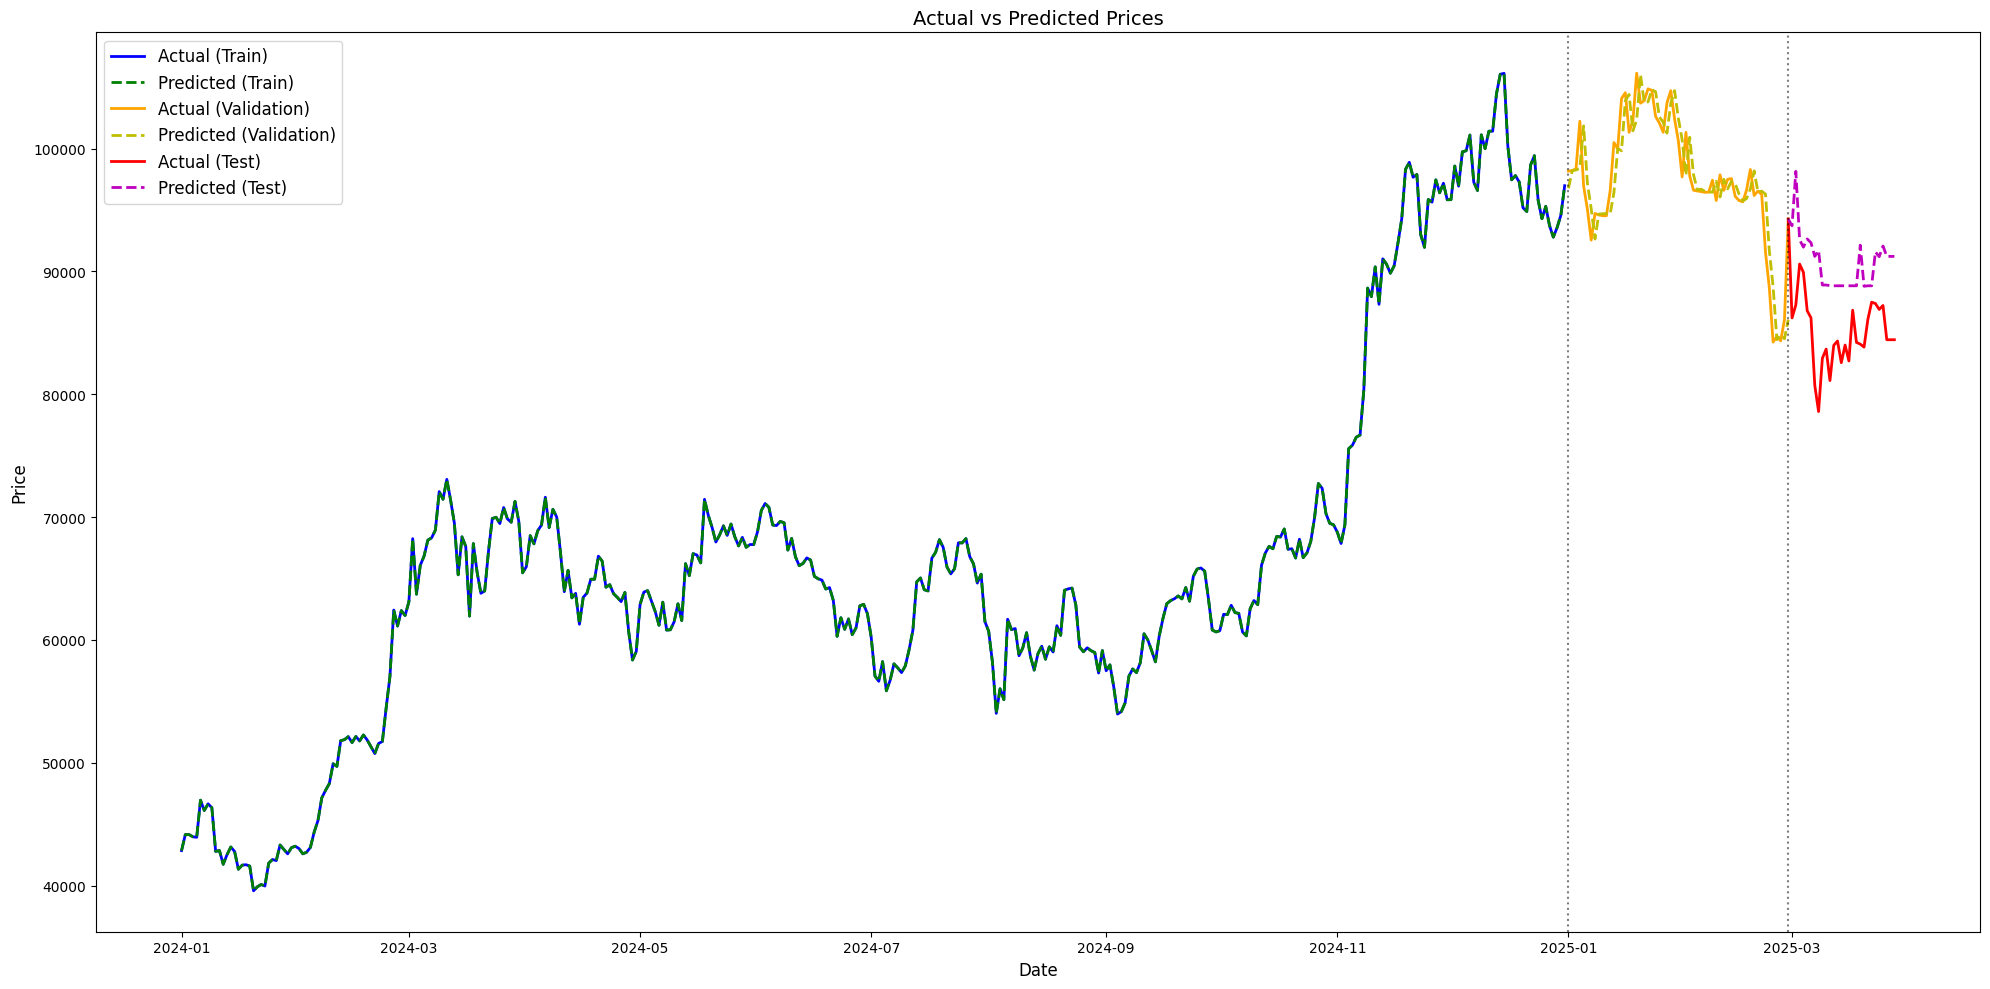

In [525]:
bayes_xg_boost_2_model, bayes_xg_boost_2_params, train_prediction_bayes, val_rediction_bayes, test_prediction_bayes = bayes_xg_boost('close_2_ahead')
plot_actual_vs_predicted(
    train_prediction_bayes,
    val_prediction_bayes,
    test_prediction_bayes,
    y_train,
    y_val,
    y_test, 
    'close_2_ahead'
)


=== Phase 1: Feature Selection ===
Index(['open', 'high', 'low', 'close', 'volume', 'SMA_5', 'SMA_10', 'SMA_15',
       'EMA_9', 'RSI', 'MACD', 'OBV', 'MFI_10', 'ATR_14', 'upper_band',
       'lower_band', 'daily_momentum', 'rolling_mean_3', 'rolling_std_3',
       'close_lag_1', 'close_lag_2'],
      dtype='object')
Removed 0 low-variance features
Feature importances:
SMA_10            9.236901e-01
high              2.423847e-02
OBV               7.710168e-03
MACD              7.275132e-03
close             6.351534e-03
upper_band        5.025411e-03
SMA_15            3.498053e-03
rolling_mean_3    3.302166e-03
low               3.254771e-03
RSI               2.997744e-03
lower_band        2.753872e-03
close_lag_2       2.425278e-03
EMA_9             2.205455e-03
ATR_14            1.758649e-03
MFI_10            1.345781e-03
SMA_5             8.357022e-04
open              4.599365e-04
rolling_std_3     3.107703e-04
daily_momentum    3.057793e-04
volume            2.549337e-04
close_la

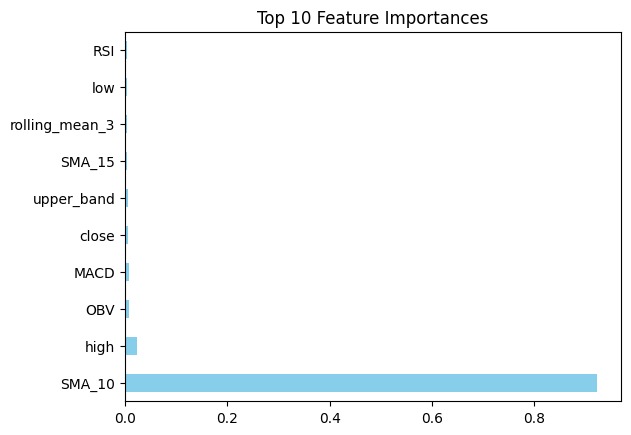


Selected 10 features:
['SMA_10', 'high', 'OBV', 'MACD', 'close', 'upper_band', 'SMA_15', 'rolling_mean_3', 'low', 'RSI']

=== Phase 2: Hyperparameter Optimization ===


[I 2025-03-31 17:21:22,910] A new study created in memory with name: no-name-75f72d72-7472-428a-8caa-be349611f215


Prediction MSE (BayesSearchCV): 33389474.56005732


[I 2025-03-31 17:21:23,747] Trial 0 finished with value: 223822653.26877394 and parameters: {'learning_rate': 0.050476008744281924, 'max_depth': 6, 'gamma': 1.4620780193766554, 'reg_alpha': 1.6564958687401732, 'reg_lambda': 3.8626936002792256, 'n_estimators': 191}. Best is trial 0 with value: 223822653.26877394.
[I 2025-03-31 17:21:24,441] Trial 1 finished with value: 221956398.07347623 and parameters: {'learning_rate': 0.05467204362500488, 'max_depth': 6, 'gamma': 1.1154870583299636, 'reg_alpha': 6.045294726608846, 'reg_lambda': 4.318753886262323, 'n_estimators': 138}. Best is trial 1 with value: 221956398.07347623.
[I 2025-03-31 17:21:25,034] Trial 2 finished with value: 216182399.27431458 and parameters: {'learning_rate': 0.0663766751415877, 'max_depth': 6, 'gamma': 0.1868785690728254, 'reg_alpha': 2.9059997961301374, 'reg_lambda': 2.3654320599736027, 'n_estimators': 147}. Best is trial 2 with value: 216182399.27431458.
[I 2025-03-31 17:21:25,368] Trial 3 finished with value: 217519

Prediction MSE (Optuna): 33293650.409438036
Best method: Optuna
Best parameters: {'learning_rate': 0.06065295219692203, 'max_depth': 5, 'gamma': 0.5734808107549819, 'reg_alpha': 2.5568436752404375, 'reg_lambda': 1.0302285849896824, 'n_estimators': 50}

=== Train Performance ===
MSE: 2799955.1539
MAE: 1302.7104
R²: 0.9873

=== Validation Performance ===
MSE: 4419621.4518
MAE: 1678.5949
R²: 0.8513

=== Test Performance ===
MSE: 17468624.5784
MAE: 2982.8145
R²: -1.7692


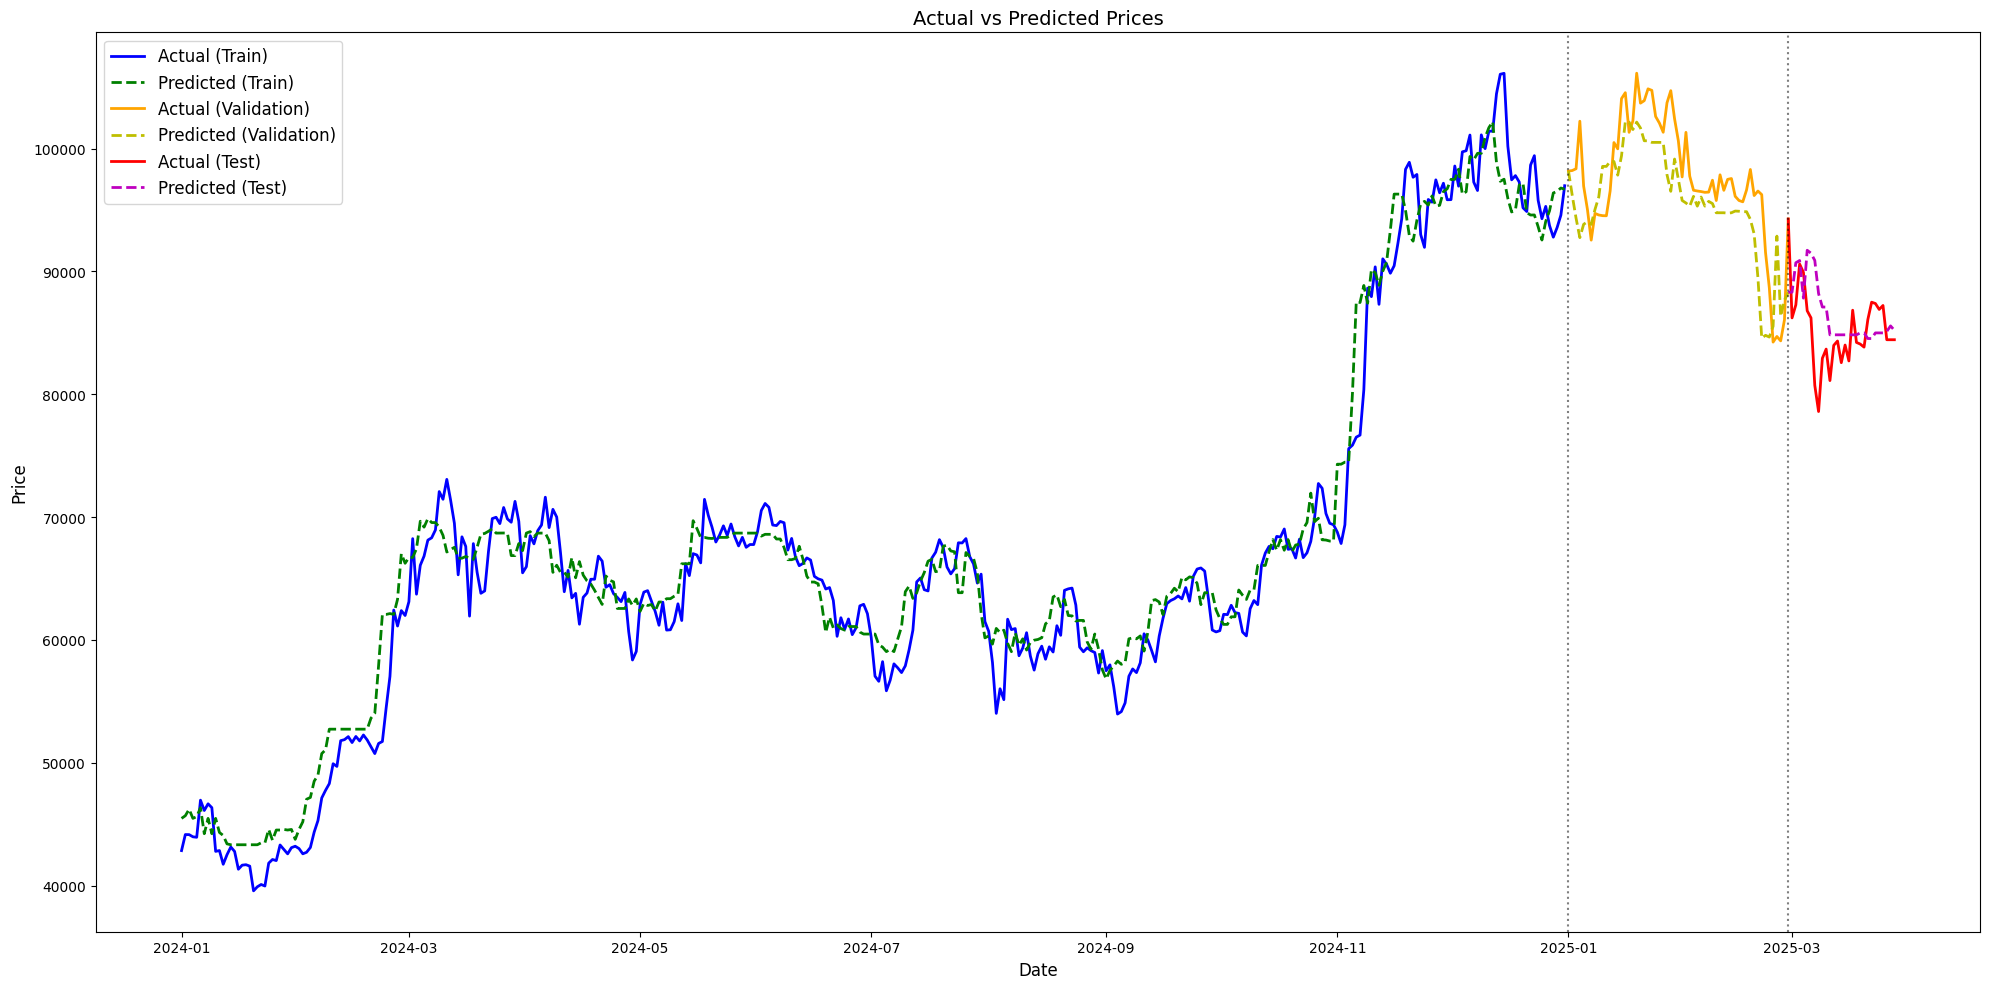

In [ ]:
bayes_xg_boost_5_model, bayes_xg_boost_5_params, train_prediction_bayes, val_prediction_bayes, test_prediction_bayes = bayes_xg_boost('close_5_ahead')

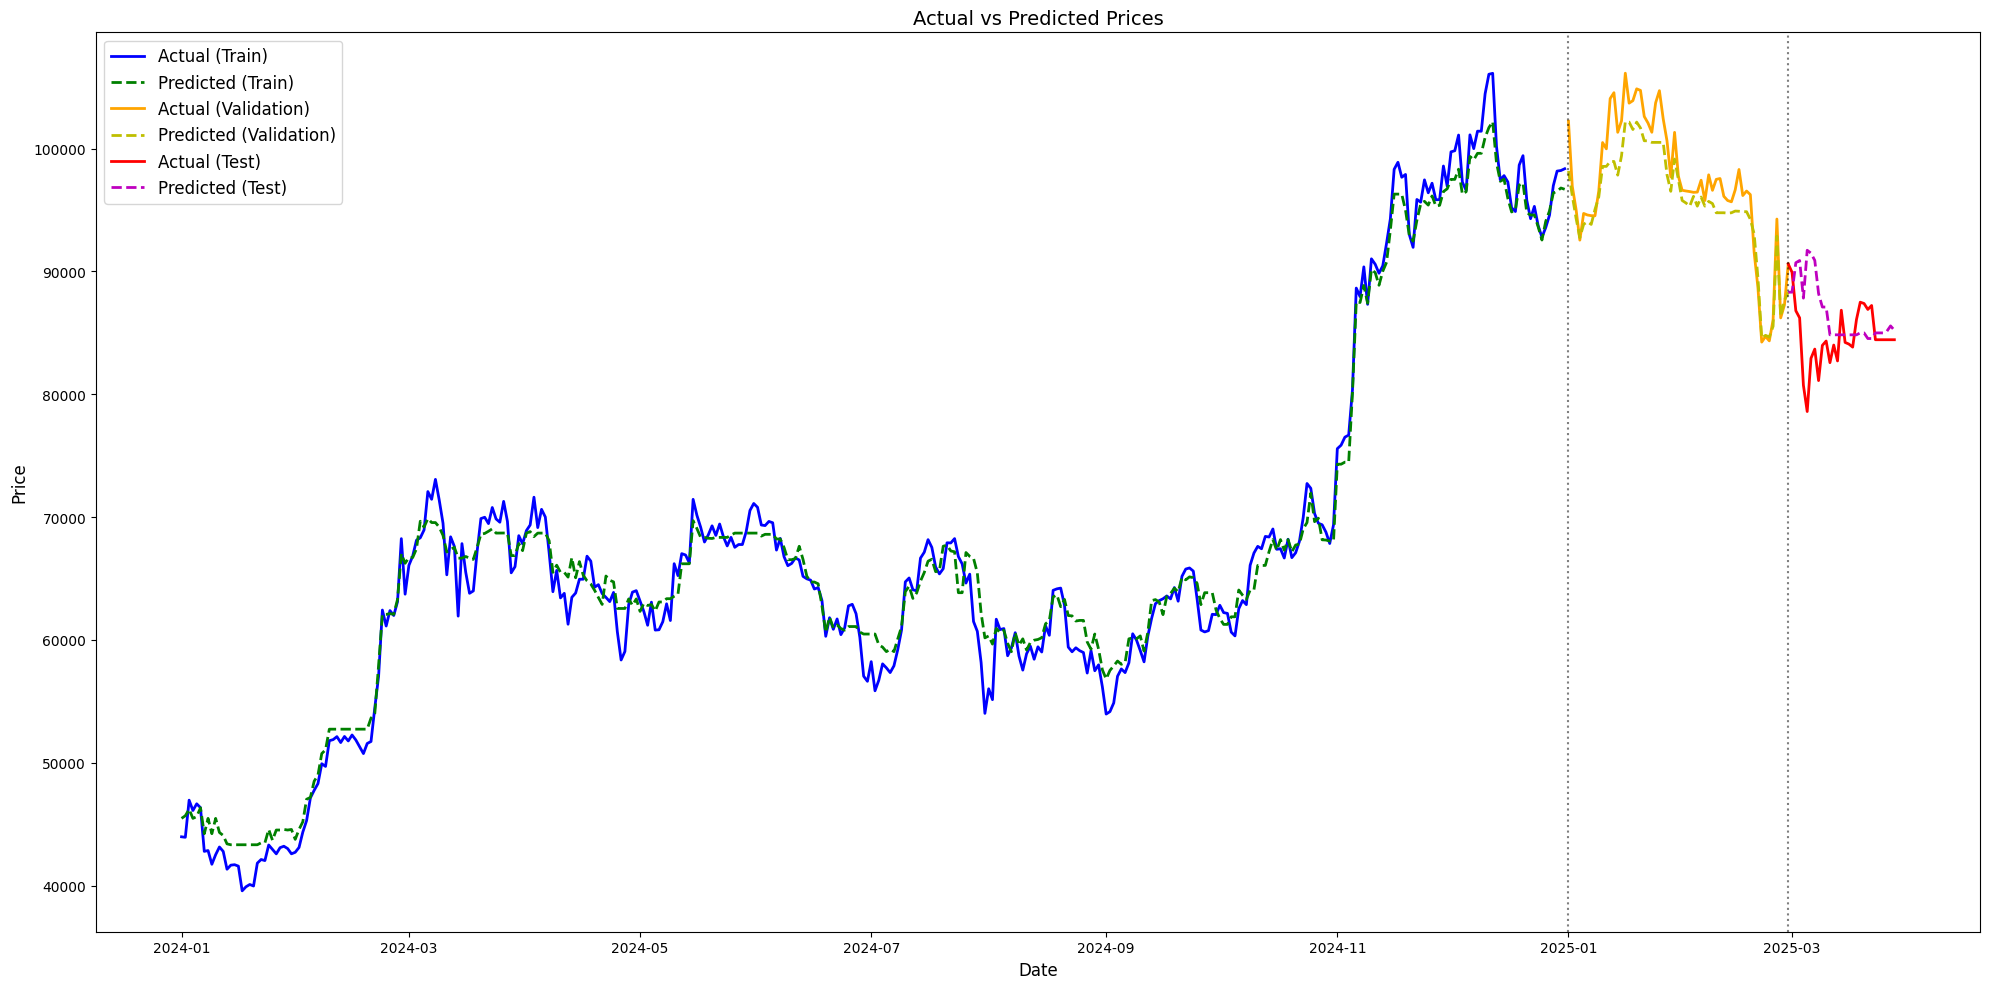

In [527]:
plot_actual_vs_predicted(
    train_prediction_bayes,
    val_prediction_bayes,
    test_prediction_bayes,
    y_train,
    y_val,
    y_test, 
    'close_5_ahead'
)

In [462]:
bayes_xg_boost_10_model, bayes_xg_boost_10_params, train_prediction_bayes, val_prediction_bayes, test_prediction_bayes = bayes_xg_boost('close_10_ahead')


Prediction MSE (gp_minimize): 35082684.26599504


[I 2025-03-29 01:24:27,865] A new study created in memory with name: no-name-08fb7df7-a4ef-4487-984d-4b9fc456598d


Prediction MSE (BayesSearchCV): 40444098.18295644


[I 2025-03-29 01:24:29,146] Trial 0 finished with value: 263424698.6628476 and parameters: {'learning_rate': 0.05206056617869067, 'max_depth': 5, 'gamma': 0.11390237868413032, 'reg_alpha': 6.189876460734466, 'reg_lambda': 1.3324970049712657, 'n_estimators': 168}. Best is trial 0 with value: 263424698.6628476.
[I 2025-03-29 01:24:29,878] Trial 1 finished with value: 260334707.19019362 and parameters: {'learning_rate': 0.05385011646280795, 'max_depth': 5, 'gamma': 0.6370576715084968, 'reg_alpha': 5.53252779456122, 'reg_lambda': 3.5047601906074504, 'n_estimators': 106}. Best is trial 1 with value: 260334707.19019362.
[I 2025-03-29 01:24:31,622] Trial 2 finished with value: 268544176.0380426 and parameters: {'learning_rate': 0.05880336142893439, 'max_depth': 7, 'gamma': 0.046961841196750245, 'reg_alpha': 1.6950735827933356, 'reg_lambda': 0.47555664611523885, 'n_estimators': 116}. Best is trial 1 with value: 260334707.19019362.
[I 2025-03-29 01:24:32,621] Trial 3 finished with value: 257200

Prediction MSE (Optuna): 42166132.58162062
Best method: gp_minimize
Best parameters: {'learning_rate': 0.5391650890419952, 'max_depth': 5, 'gamma': 1.5875384948659486, 'alpha': 4.1048890577663, 'lambda': 4.069918962929687}
Train MSE: 13.220547132015241
Validation MSE: 35082684.26599504
Test MSE (Final Model): 73546483.80656613


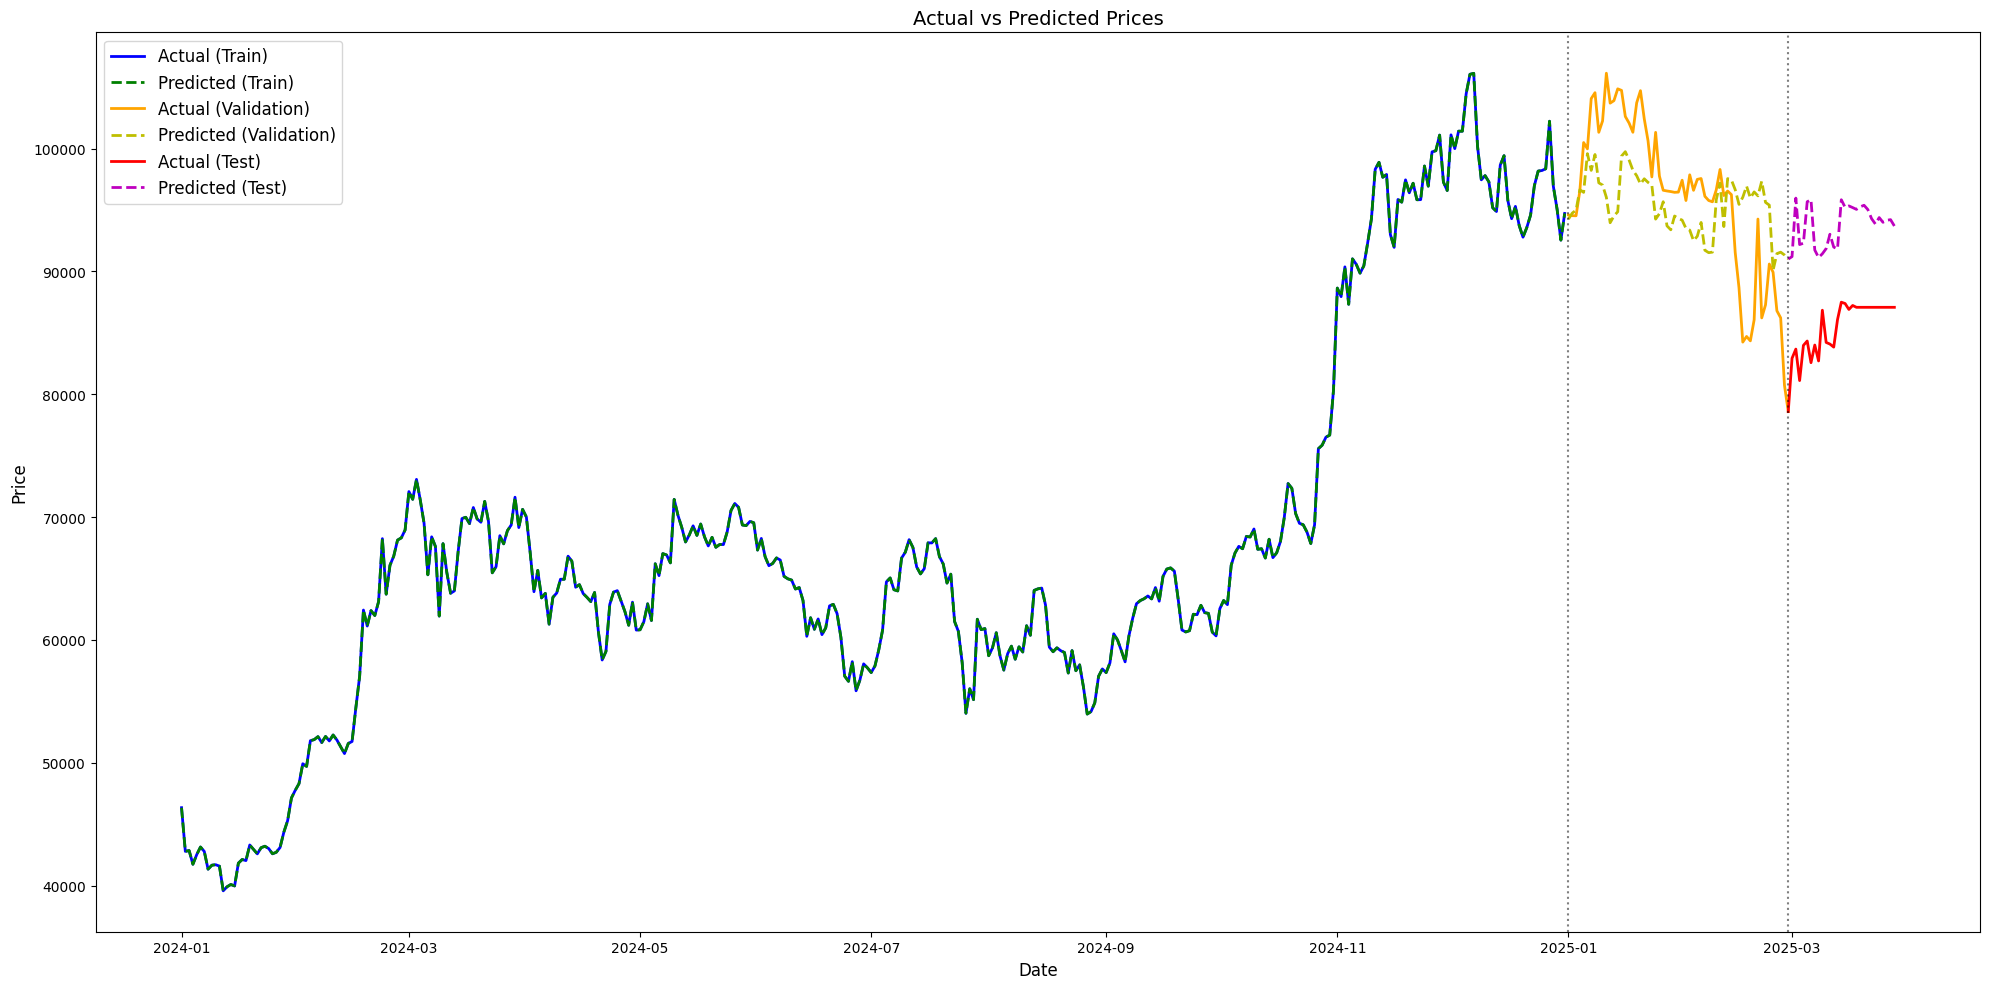

In [467]:
plot_actual_vs_predicted(
    train_prediction_bayes,
    val_prediction_bayes,
    test_prediction_bayes,
    y_train,
    y_val,
    y_test, 
    'close_10_ahead'
)

# Linear Regression Model 

### Hyperparameter tuining using Lasso for feature selection

In [9]:
def train_lasso_model(X_train, X_val, X_test, y_train, y_val, y_test, target_var):

    print("=== Phase 1: Initial Feature Preprocessing ===")
    # Step 1: Remove low-variance features
    selector = VarianceThreshold(threshold=0.01)
    X_train_filtered = selector.fit_transform(X_train)
    selected_feature_indices = selector.get_support(indices=True)
    selected_features = X_train.columns[selected_feature_indices]
    print(f"Removed {X_train.shape[1] - len(selected_features)} low-variance features")
    
    # Apply to all datasets
    X_train_reduced = X_train[selected_features]
    X_val_reduced = X_val[selected_features]
    X_test_reduced = X_test[selected_features]
    
    # Step 2: Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_reduced)
    X_val_scaled = scaler.transform(X_val_reduced)
    X_test_scaled = scaler.transform(X_test_reduced)
    
    # Prepare target variables
    y_train_target = y_train[target_var].values.ravel()
    y_val_target = y_val[target_var].values.ravel()

    print("\n=== Phase 2: Hyperparameter Tuning ===")
    # Time series cross-validation for alpha selection
    tscv = TimeSeriesSplit(n_splits=5)
    alphas = np.logspace(-4, 2, 50)  # Wider range of alphas
    
    lasso_grid = GridSearchCV(
        Lasso(max_iter=10000, tol=1e-4),
        param_grid={'alpha': alphas},
        cv=tscv,
        scoring='neg_mean_squared_error'
    )
    lasso_grid.fit(X_train_scaled, y_train_target)
    
    best_alpha = lasso_grid.best_params_['alpha']
    print(f"Best alpha from CV: {best_alpha:.4f}")

    print("\n=== Phase 3: Feature Selection ===")
    # Train with best alpha to get coefficients
    lasso = Lasso(alpha=best_alpha, max_iter=10000)
    lasso.fit(X_train_scaled, y_train_target)
    
    # Select non-zero coefficient features
    selected_mask = lasso.coef_ != 0
    selected_features = selected_features[selected_mask]
    print(f'Selected features:\n{selected_features}\n{len(selected_features)} features')
    
    
    # Filter datasets to only selected features
    X_train_final = X_train_reduced[selected_features]
    X_val_final = X_val_reduced[selected_features]
    X_test_final = X_test_reduced[selected_features]
    
    # Re-scale the selected features
    final_scaler = StandardScaler()
    X_train_final_scaled = final_scaler.fit_transform(X_train_final)
    X_val_final_scaled = final_scaler.transform(X_val_final)
    
    print("\n=== Phase 4: Final Model Training ===")
    # Combine train + val for final model
    X_train_val = np.vstack([X_train_final_scaled, X_val_final_scaled])
    y_train_val = np.concatenate([y_train_target, y_val_target])
    
    final_model = Lasso(alpha=best_alpha, max_iter=10000)
    final_model.fit(X_train_val, y_train_val)

    
    print("\n=== Phase 5: Evaluation ===")
    # Evaluate model on train, val, and test sets
    y_train_pred = lasso.predict(X_train_scaled)
    y_val_pred = lasso.predict(X_val_scaled)
    y_test_pred = lasso.predict(X_test_scaled)

    print("\n=== Train Performance ===")
    print(f"MSE: {mean_squared_error(y_train[target_var], y_train_pred):.4f}")
    print(f"MAE: {mean_absolute_error(y_train[target_var], y_train_pred):.4f}")
    print(f"R²: {r2_score(y_train[target_var], y_train_pred):.4f}")

    print("\n=== Validation Performance ===")
    print(f"MSE: {mean_squared_error(y_val[target_var], y_val_pred):.4f}")
    print(f"MAE: {mean_absolute_error(y_val[target_var], y_val_pred):.4f}")
    print(f"R²: {r2_score(y_val[target_var], y_val_pred):.4f}")

    print("\n=== Test Performance ===")
    print(f"MSE: {mean_squared_error(y_test[target_var], y_test_pred):.4f}")
    print(f"MAE: {mean_absolute_error(y_test[target_var], y_test_pred):.4f}")
    print(f"R²: {r2_score(y_test[target_var], y_test_pred):.4f}")
    
    return X_train_scaled, X_val_scaled, X_test_scaled, y_train_pred, y_val_pred, y_test_pred, lasso

=== Phase 1: Initial Feature Preprocessing ===
Removed 0 low-variance features

=== Phase 2: Hyperparameter Tuning ===


c:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.774e+07, tolerance: 2.071e+05
  model = cd_fast.enet_coordinate_descent(
c:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.511e+08, tolerance: 1.475e+06
  model = cd_fast.enet_coordinate_descent(
c:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.204e+08, tolerance: 1.865e+06
  model = cd_fast.enet_

Best alpha from CV: 42.9193

=== Phase 3: Feature Selection ===
Selected features:
Index(['high', 'low', 'close', 'SMA_10', 'RSI', 'OBV', 'MFI_10', 'upper_band',
       'daily_momentum', 'rolling_std_3'],
      dtype='object')
10 features

=== Phase 4: Final Model Training ===

=== Phase 5: Evaluation ===

=== Train Performance ===
MSE: 3234317.2931
MAE: 1290.1130
R²: 0.9850

=== Validation Performance ===
MSE: 4469193.2351
MAE: 1649.3604
R²: 0.8213

=== Test Performance ===
MSE: 8439339.5641
MAE: 2071.5965
R²: 0.0912


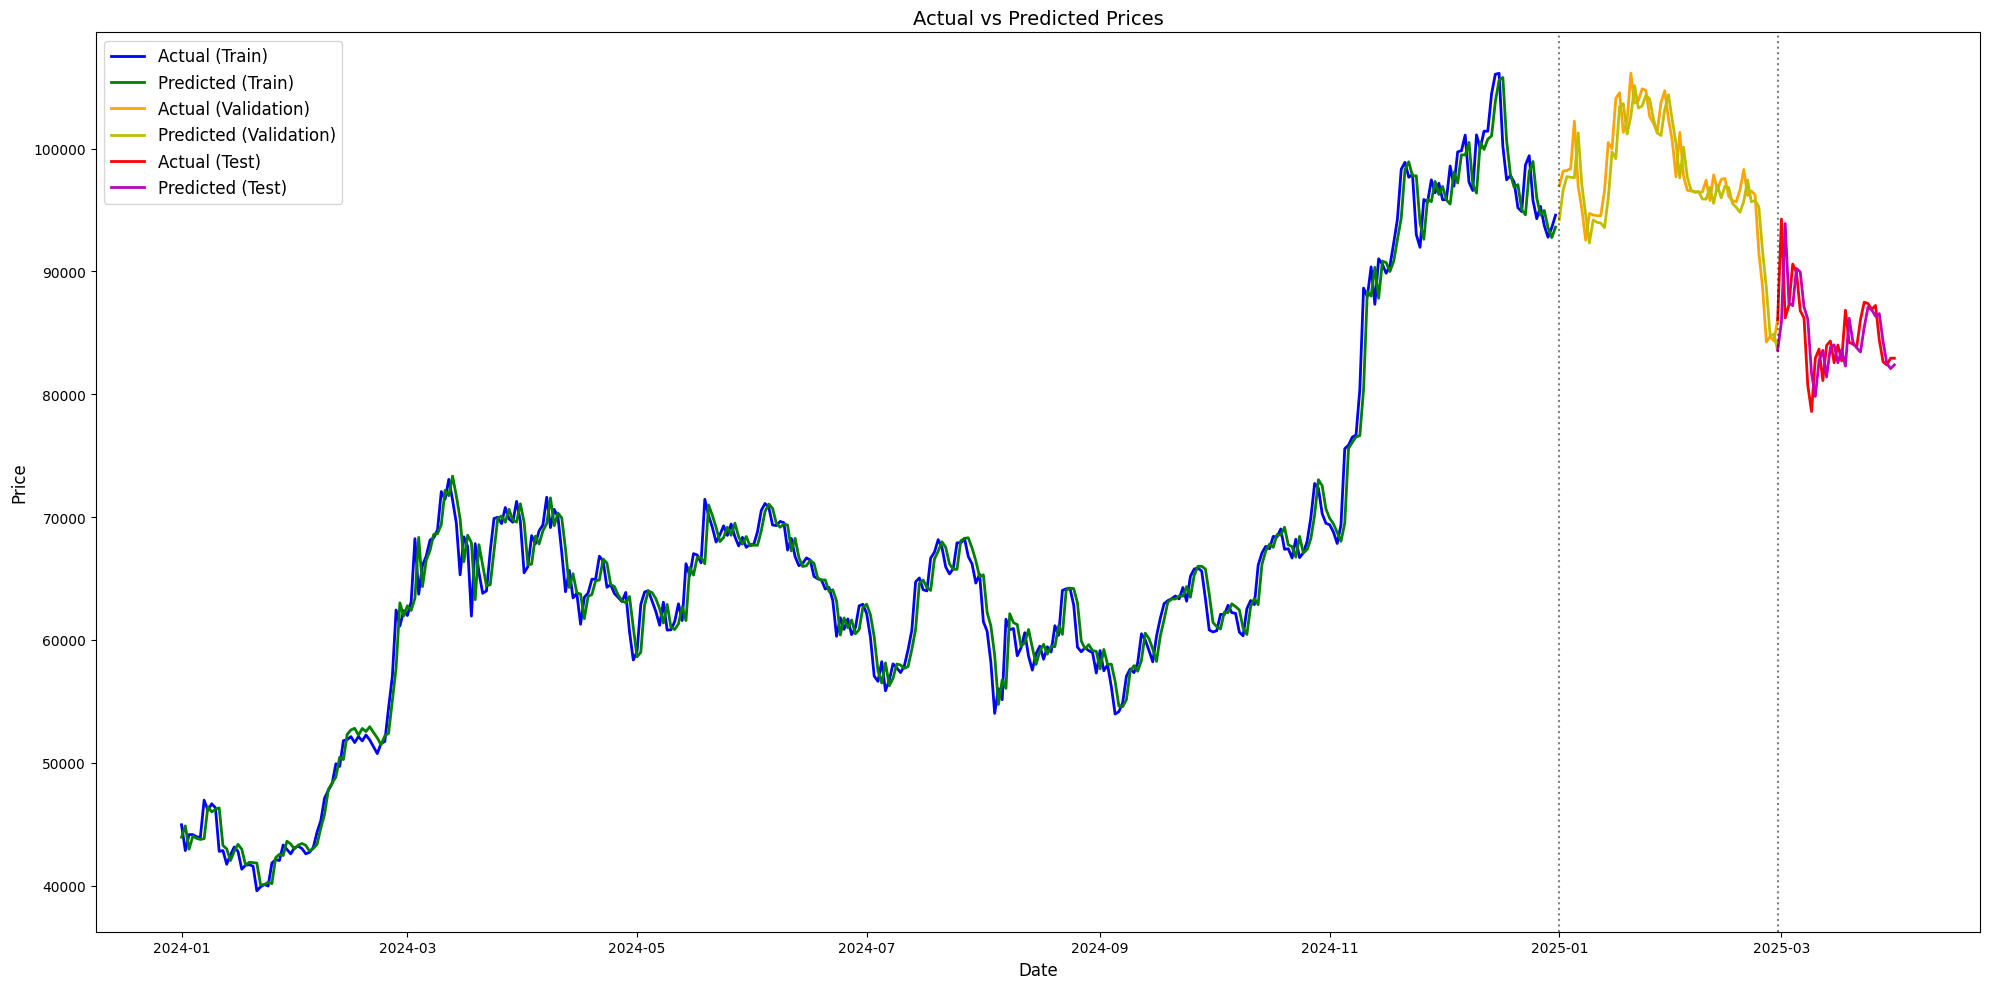

In [21]:
X_train_scaled, X_val_scaled, X_test_scaled, train_pred_lasso, val_pred_lasso, test_pred_lasso, lasso_model = train_lasso_model(
    X_train, X_val, X_test, y_train, y_val, y_test, 'close_1_ahead'
)
plot_actual_vs_predicted(
    train_pred_lasso, val_pred_lasso, test_pred_lasso,
    y_train,
    y_val,
    y_test, 
    'close_1_ahead'
)

=== Phase 1: Initial Feature Preprocessing ===
Removed 0 low-variance features

=== Phase 2: Hyperparameter Tuning ===


c:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.377e+07, tolerance: 2.327e+05
  model = cd_fast.enet_coordinate_descent(
c:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.364e+08, tolerance: 1.464e+06
  model = cd_fast.enet_coordinate_descent(
c:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.482e+08, tolerance: 1.843e+06
  model = cd_fast.enet_

Best alpha from CV: 75.4312

=== Phase 3: Feature Selection ===
Selected features:
Index(['high', 'low', 'close', 'SMA_10', 'RSI', 'OBV', 'MFI_10', 'upper_band',
       'daily_momentum'],
      dtype='object')
9 features

=== Phase 4: Final Model Training ===

=== Phase 5: Evaluation ===

=== Train Performance ===
MSE: 6106341.3351
MAE: 1827.3982
R²: 0.9719

=== Validation Performance ===
MSE: 10381772.7317
MAE: 2363.5182
R²: 0.5879

=== Test Performance ===
MSE: 12311646.4690
MAE: 2588.4216
R²: -0.3121


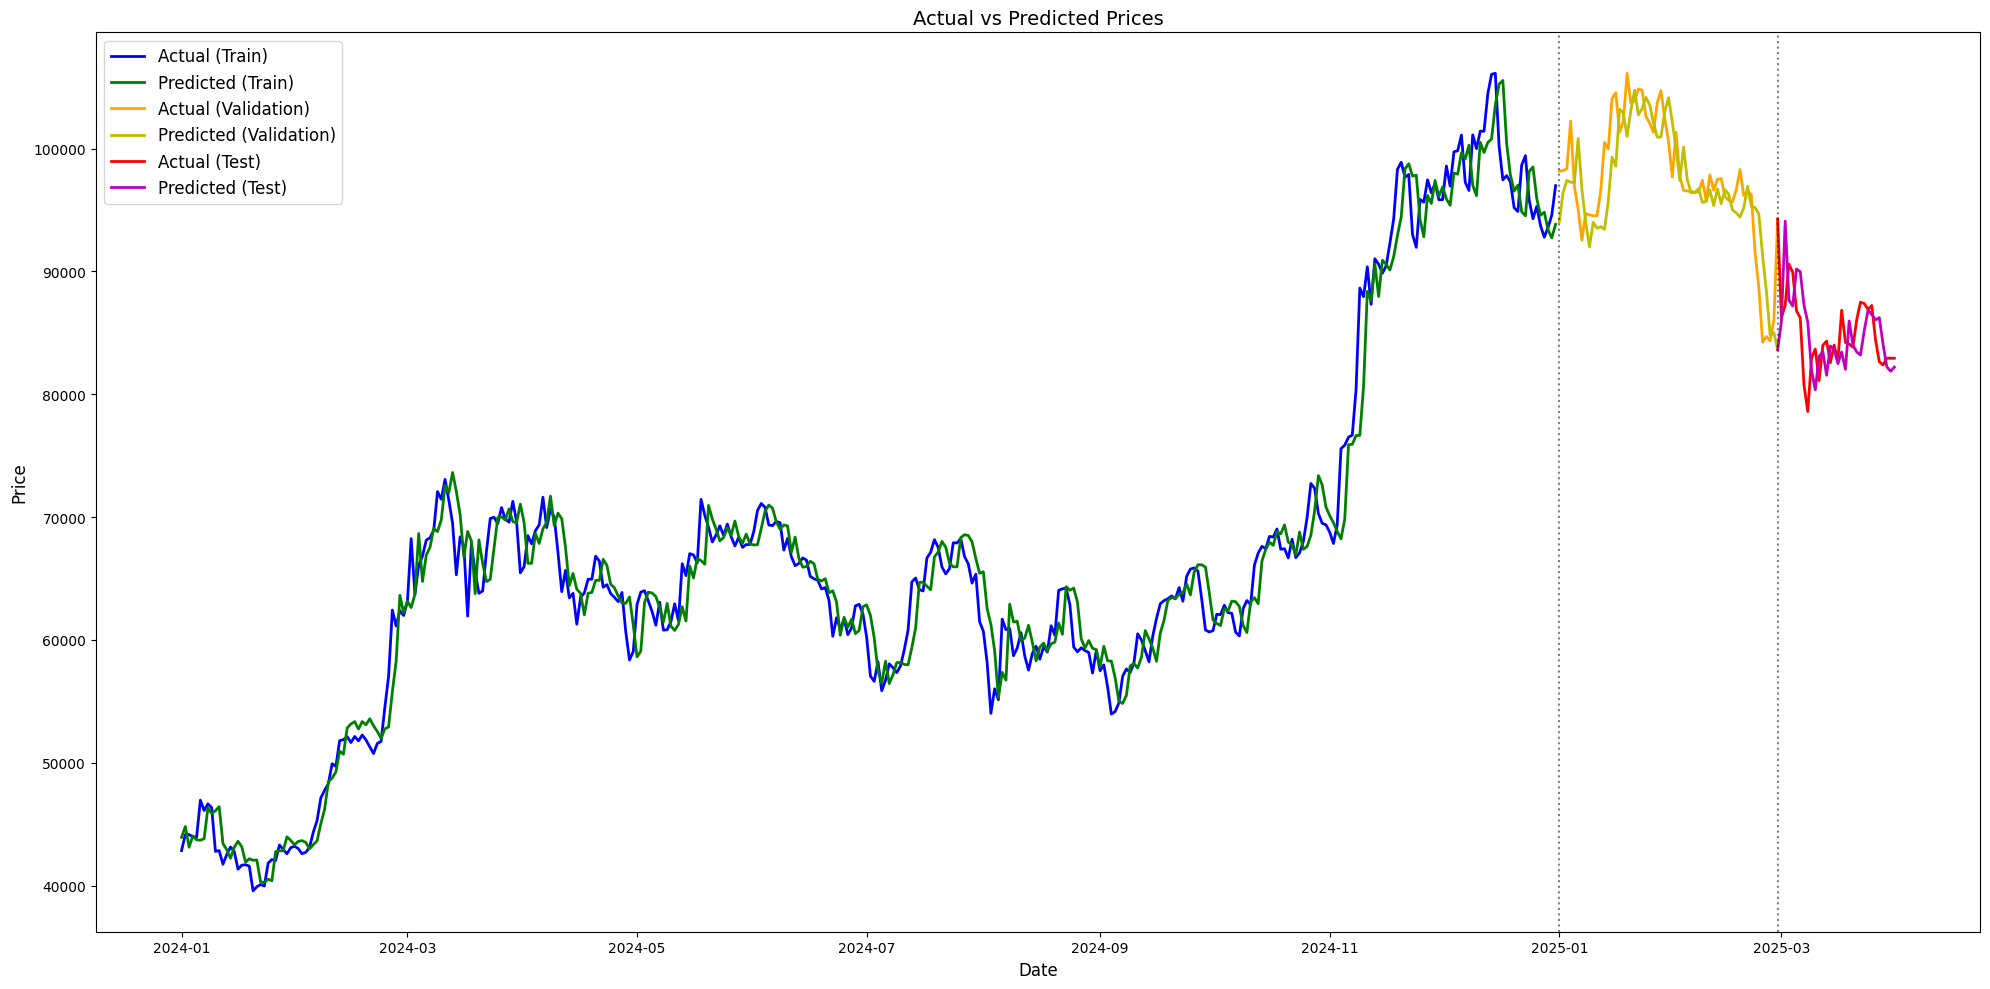

In [20]:
X_train_scaled, X_val_scaled, X_test_scaled, train_pred_lasso, val_pred_lasso, test_pred_lasso, lasso_model = train_lasso_model(
    X_train, X_val, X_test, y_train, y_val, y_test, 'close_2_ahead'
)
plot_actual_vs_predicted(
    train_pred_lasso, val_pred_lasso, test_pred_lasso,
    y_train,
    y_val,
    y_test, 
    'close_2_ahead'
)

=== Phase 1: Initial Feature Preprocessing ===
Removed 0 low-variance features

=== Phase 2: Hyperparameter Tuning ===


c:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.009e+07, tolerance: 3.298e+05
  model = cd_fast.enet_coordinate_descent(
c:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.393e+08, tolerance: 1.423e+06
  model = cd_fast.enet_coordinate_descent(
c:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.736e+08, tolerance: 1.766e+06
  model = cd_fast.enet_

Best alpha from CV: 75.4312

=== Phase 3: Feature Selection ===
Selected features:
Index(['high', 'low', 'close', 'volume', 'SMA_5', 'RSI', 'OBV', 'MFI_10',
       'upper_band', 'lower_band', 'daily_momentum', 'rolling_std_3'],
      dtype='object')
12 features

=== Phase 4: Final Model Training ===

=== Phase 5: Evaluation ===

=== Train Performance ===
MSE: 14102443.5643
MAE: 2909.6779
R²: 0.9363

=== Validation Performance ===
MSE: 21408654.1825
MAE: 3469.4139
R²: 0.2796

=== Test Performance ===
MSE: 18016626.7422
MAE: 3315.9464
R²: -1.7817


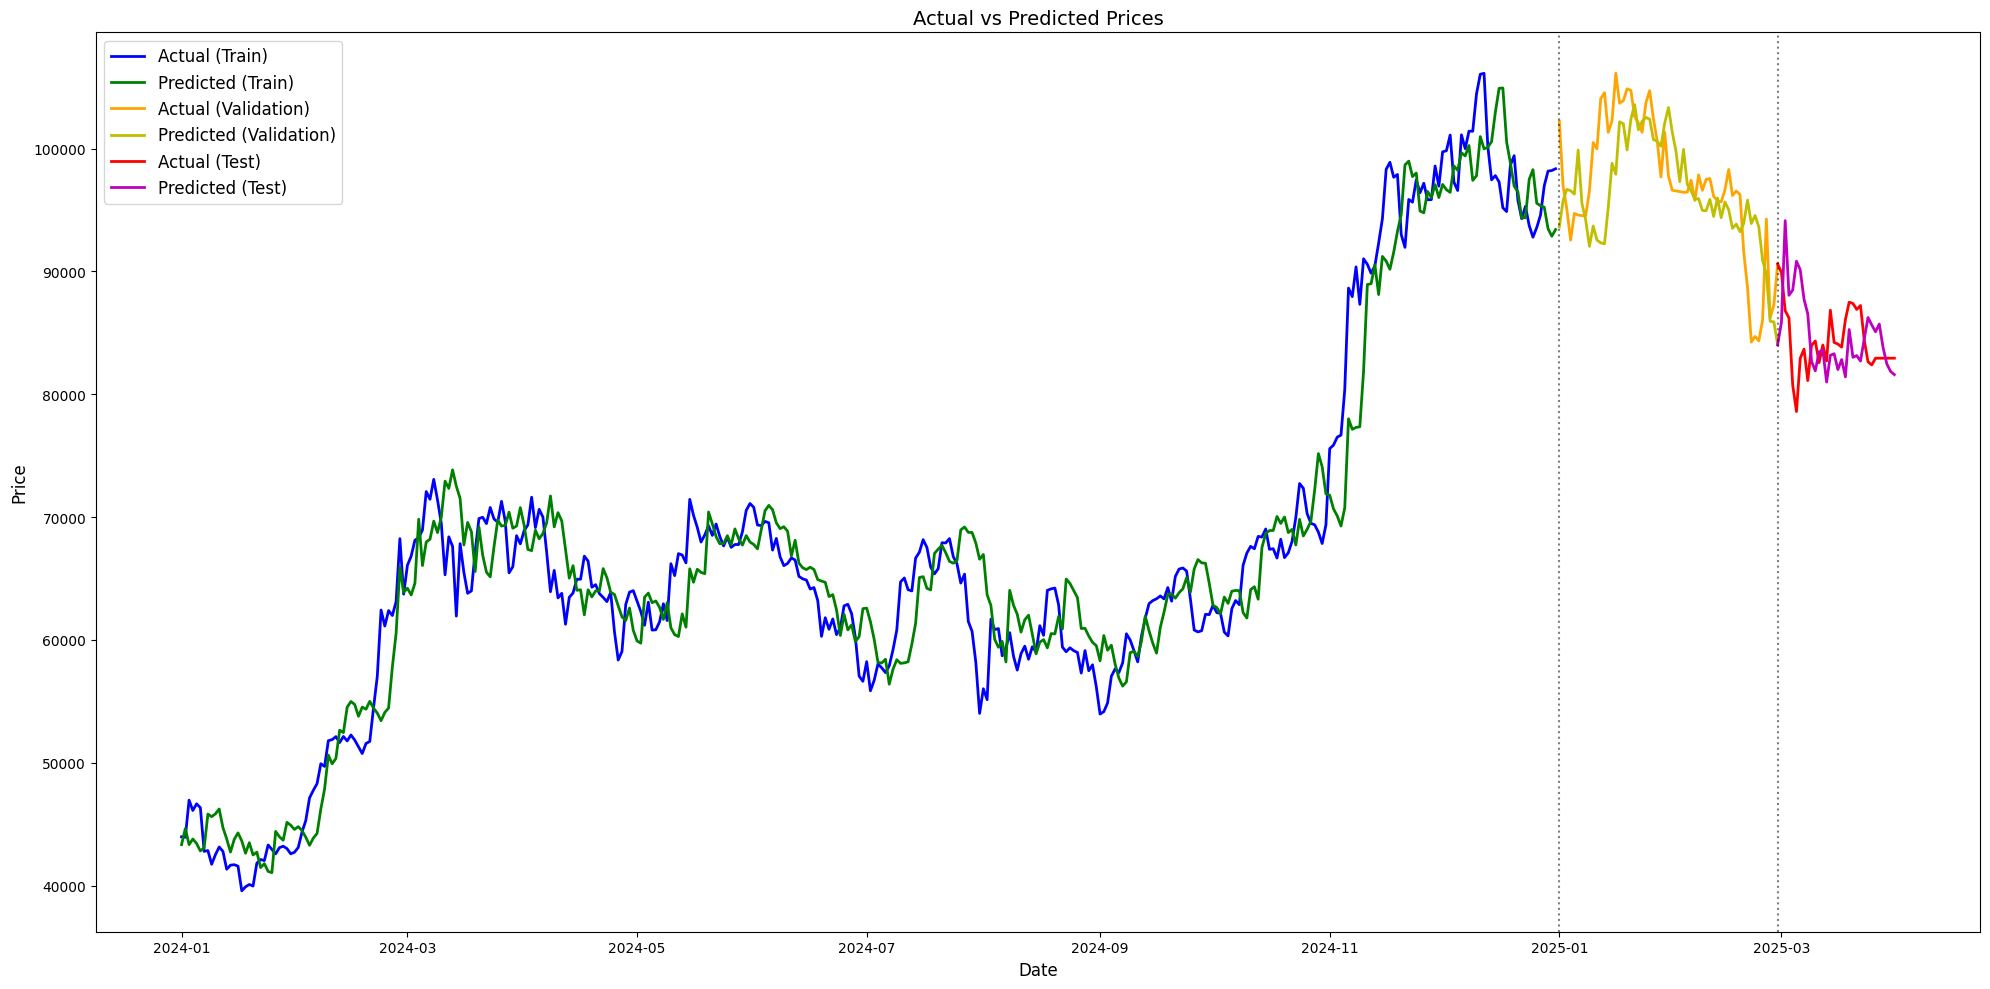

In [22]:
X_train_scaled, X_val_scaled, X_test_scaled, train_pred_lasso, val_pred_lasso, test_pred_lasso, lasso_model = train_lasso_model(
    X_train, X_val, X_test, y_train, y_val, y_test, 'close_5_ahead'
)
plot_actual_vs_predicted(
    train_pred_lasso, val_pred_lasso, test_pred_lasso,
    y_train,
    y_val,
    y_test, 
    'close_5_ahead'
)

In [483]:
def train_elasticnet_model(X_train, X_test, X_val, y_train, y_val, target_var):
    # Combine train and validation sets
    X_train_val = pd.concat([X_train, X_val])
    y_train_val = pd.concat([y_train, y_val])
    
    # Step 1: Scale features with RobustScaler
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train_val)
    X_test_scaled = scaler.transform(X_test)
    
    # Step 2: Remove low-variance features
    selector = VarianceThreshold(threshold=0.1)
    X_train_reduced = selector.fit_transform(X_train_scaled)
    X_test_reduced = selector.transform(X_test_scaled)
    
    # Get feature names after variance threshold
    kept_mask = selector.get_support()
    remaining_features = X_train.columns[kept_mask]
    removed_variance = X_train.columns[~kept_mask]
    print(f"\nRemoved {len(removed_variance)} low-variance features:", removed_variance.tolist())
    
    # Step 3: Remove highly correlated features
    corr_matrix = pd.DataFrame(X_train_reduced, columns=remaining_features).corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
    
    # Apply correlation-based feature removal
    feature_mask = [True if feat not in to_drop else False for feat in remaining_features]
    X_train_final = X_train_reduced[:, feature_mask]
    X_test_final = X_test_reduced[:, feature_mask]
    final_features = remaining_features[feature_mask]
    
    print(f"\nRemoved {len(to_drop)} highly correlated features:", to_drop)
    print(f"\nFinal {len(final_features)} features:", final_features.tolist())
    
    # Time-series cross-validated grid search
    tscv = TimeSeriesSplit(n_splits=5)
    enet_cv = GridSearchCV(
        ElasticNet(warm_start=True),
        param_grid={
            'alpha': [0.1, 1, 10],
            'l1_ratio': [0.5, 0.7],
            'max_iter': [10_000],
            'tol': [1e-3]
        },
        cv=tscv,
        scoring='neg_mean_squared_error',
        n_jobs=-1  # Parallel processing
    )
    
    enet_cv.fit(X_train_final, y_train_val[target_var])
    
    print(f'\nBest params: {enet_cv.best_params_}')
    print(f'Best score: {-enet_cv.best_score_:.4f} (MSE)')
    
    return {
        'best_params': enet_cv.best_params_,
        'X_train': X_train_final,
        'X_test': X_test_final,
        'features': final_features,
        'scaler': scaler,
        'variance_selector': selector,
        'correlation_dropped': to_drop
    }

# Usage
result = train_elasticnet_model(X_train, X_test, X_val, y_train, y_val, 'close_1_ahead')
best_params_en_1 = result['best_params']
X_train_final = result['X_train']
X_test_final = result['X_test']


Removed 0 low-variance features: []

Removed 15 highly correlated features: ['high', 'low', 'close', 'SMA_5', 'SMA_7', 'SMA_10', 'SMA_15', 'SMA_30', 'EMA_9', 'RSI', 'close_lag_1', 'close_lag_2', 'upper_band', 'lower_band', 'rolling_mean_3']

Final 8 features: ['open', 'volume', 'MACD', 'OBV', 'MFI_10', 'ATR_14', 'daily_momentum', 'rolling_std_3']

Best params: {'alpha': 0.1, 'l1_ratio': 0.7, 'max_iter': 10000, 'tol': 0.001}
Best score: 62192840.7335 (MSE)


In [ ]:
# Predict future prices
def es_model(best_params_en, X_train, X_val, X_test_scaled, y_train, y_val, y_test, target_var):

    scaler = RobustScaler()
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    es_model = ElasticNet(**best_params_en)
    es_model.fit(X_train_scaled, y_train[target_var])
    
    y_pred_train = es_model.predict(X_train_scaled)
    y_pred_val = es_model.predict(X_val_scaled)
    y_pred_test = es_model.predict(X_test_scaled)

    train_score = r2_score(y_train[target_var], y_pred_train)
    val_score = r2_score(y_val[target_var], y_pred_val)
    test_score = r2_score(y_test[target_var], y_pred_test)
    
    print(f'Training R²: {train_score:.4f}')
    print(f'Validation R²: {val_score:.4f}')
    print(f'Test R²: {test_score:.4f}')

    return y_pred_train, y_pred_val, y_pred_test, es_model

train_pred_es_close_1, val_pred_es_close_1, test_pred_es_close_1, es_model_close_1 = es_model(best_params_en_1, X_train, X_val, X_test_scaled, y_train, y_val, y_test, 'close_1_ahead')

Training R²: 0.9851
Validation R²: 0.8150
Test R²: -19.4727


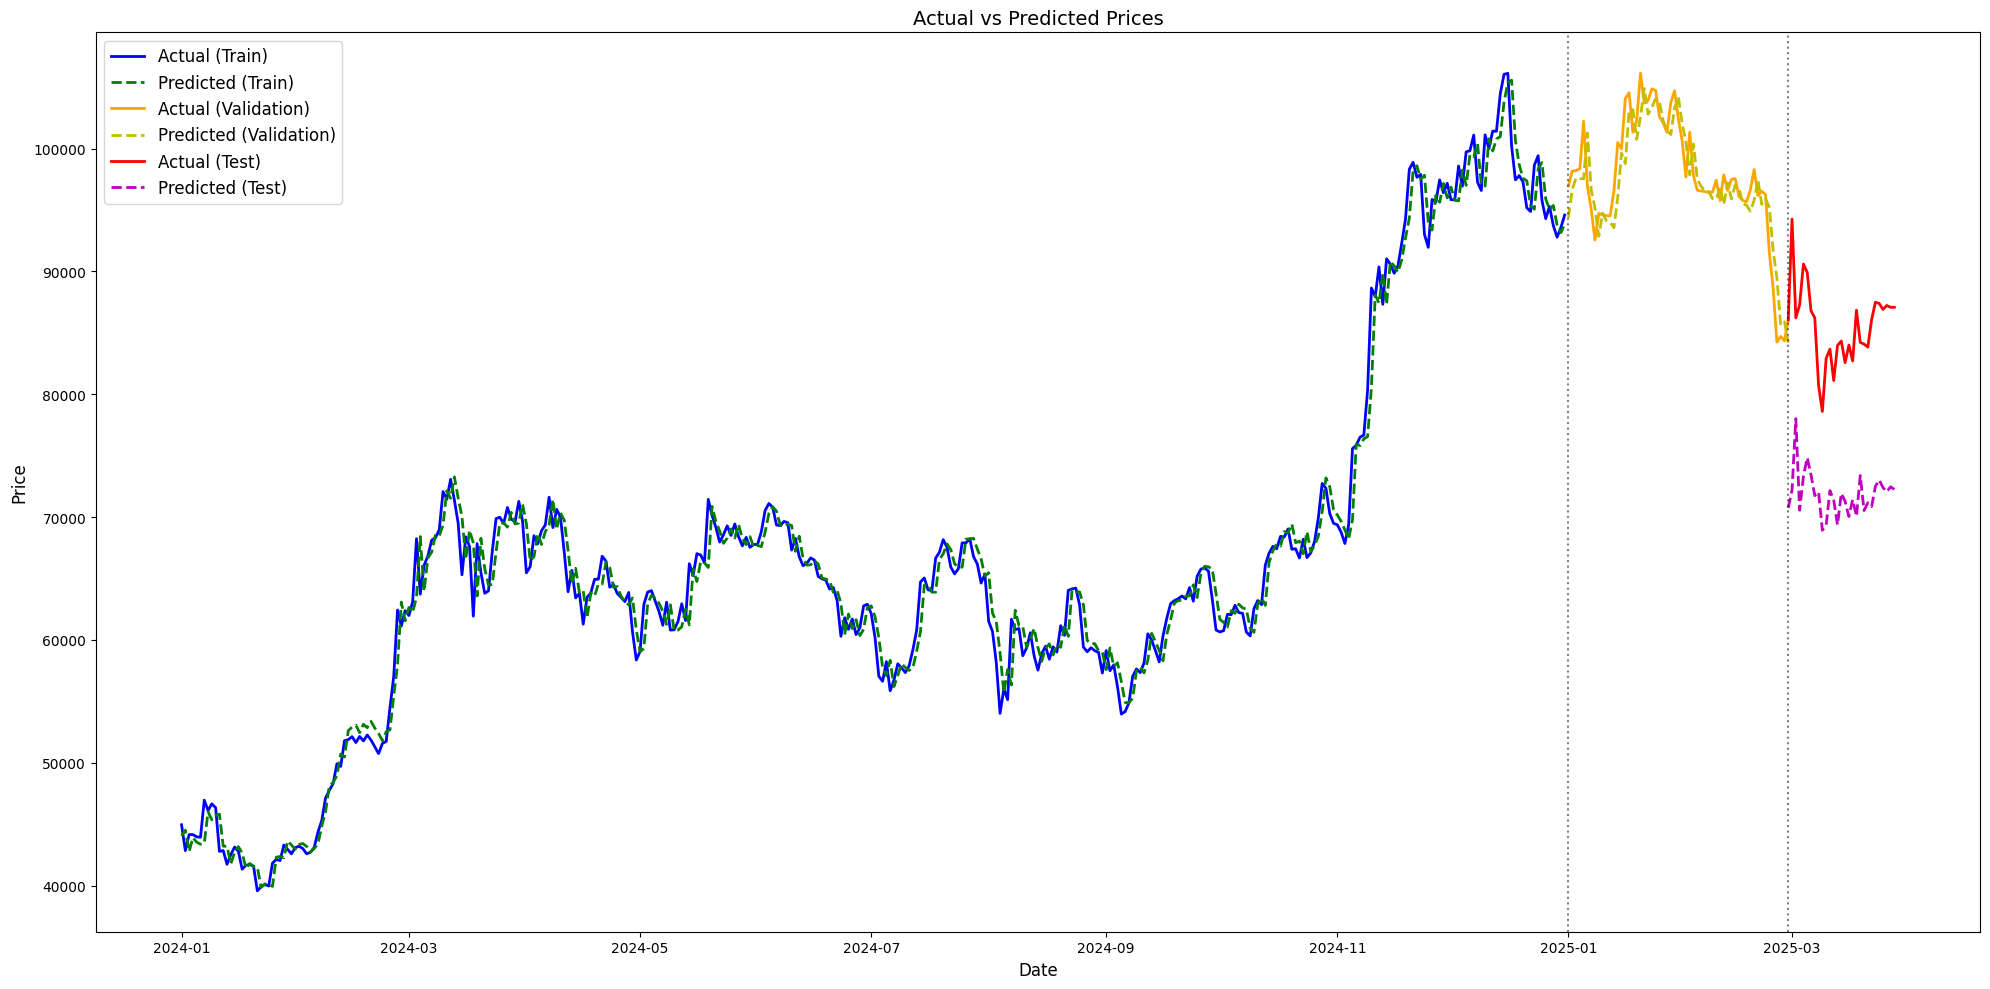

In [489]:
plot_actual_vs_predicted(train_pred_es_close_1, val_pred_es_close_1, test_pred_es_close_1, y_train,  y_val, y_test, 'close_1_ahead')

### Develop Trading Strategy

In [48]:
from skopt import gp_minimize

# Define the objective function for weight optimization
def objective(weights):
    # Combine predictions using the weights
    combined_pred = (weights[0] * train_data['Pred_1_day'] +
                     weights[1] * train_data['Pred_2_day'] +
                     weights[2] * train_data['Pred_5_day'] +
                     weights[3] * train_data['Pred_10_day'] +
                     weights[4] * train_data['Pred_20_day'] +
                     weights[5] * train_data['Pred_30_day'])
    
    # Calculate the Sharpe ratio (or any other metric)
    returns = combined_pred.pct_change().dropna()
    sharpe_ratio = returns.mean() / returns.std()
    return -sharpe_ratio  # Minimize the negative Sharpe ratio

# Define the search space for weights
weight_space = [(0, 1) for _ in range(6)]

# Bayesian Optimization for weight optimization
res = gp_minimize(objective, weight_space, n_calls=50, random_state=42)
best_weights = res.x

KeyError: 'Pred_2_day'

## ARIMA

Preprocess Data

In [ ]:
# Create a new DataFrame with a clone of btc_data including the timestamp column
arima_df = btc_data.copy()
def calculate_weighted_averages(data, lags):
    for i in range(1, lags+1):
        
arima_df = btc_data[['close', 'SMA', 'EMA', 'RSI', 'MACD', 'MACD_signal', 'MACD_hist', 'OBV', 'MFI', 'ATR', 'upper_band', 'middle_band', 'lower_band', 'BBW', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'weighted_avg']].copy()
arima_df.reset_index(inplace=True)
print(arima_df.head())

   timestamp     close       SMA       EMA        RSI      MACD  MACD_signal  \
0 2024-03-05  63724.01 -0.513488 -0.456481  77.822116  0.078483  1008.875495   
1 2024-03-06  66074.04 -0.513488 -0.456481  77.822116  0.078483  1008.875495   
2 2024-03-07  66823.17 -0.513488 -0.456481  77.822116  0.078483  1008.875495   
3 2024-03-08  68124.19 -0.513488 -0.456481  77.822116  0.078483  1008.875495   
4 2024-03-09  68313.27 -0.513488 -0.456481  77.822116  0.078483  1008.875495   

    MACD_hist       OBV        MFI  ...    upper_band  middle_band  \
0 -145.010934  0.777210  80.743988  ...  74118.585226   66980.6605   
1 -145.010934  1.141570  80.743988  ...  74118.585226   66980.6605   
2 -145.010934  1.387102  80.743988  ...  74118.585226   66980.6605   
3 -145.010934  1.730745  80.743988  ...  74118.585226   66980.6605   
4 -145.010934  1.822706  80.743988  ...  74118.585226   66980.6605   

     lower_band       BBW     lag_1     lag_2     lag_3     lag_4     lag_5  \
0  59842.735774  0.

In [22]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np

# Assuming 'data' is your DataFrame and 'date' is your timestamp column
arima_df['timestamp'] = pd.to_datetime(arima_df['timestamp'])  # Ensure date column is datetime
arima_df.set_index('timestamp', inplace=True)

# Check for missing values and fill them if needed
arima_df = arima_df.fillna(method='ffill') # Forward fill missing values

# Perform Augmented Dickey-Fuller test for stationarity
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is non-stationary.")

# Check stationarity on 'close' price
adf_test(arima_df['close'])


ADF Statistic: -1.3102930665164187
p-value: 0.6244501652162752
The series is non-stationary.


C:\Users\ryant\AppData\Local\Temp\ipykernel_27940\3696961266.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  arima_df = arima_df.fillna(method='ffill') # Forward fill missing values


Difference the df to make it stationary

In [23]:
# First-order differencing to make the series stationary
arima_df['close_diff'] = arima_df['close'] - arima_df['close'].shift(1)

# Perform the ADF test again on the differenced series
adf_test(arima_df['close_diff'].dropna())

ADF Statistic: -20.611240059895128
p-value: 0.0
The series is stationary.


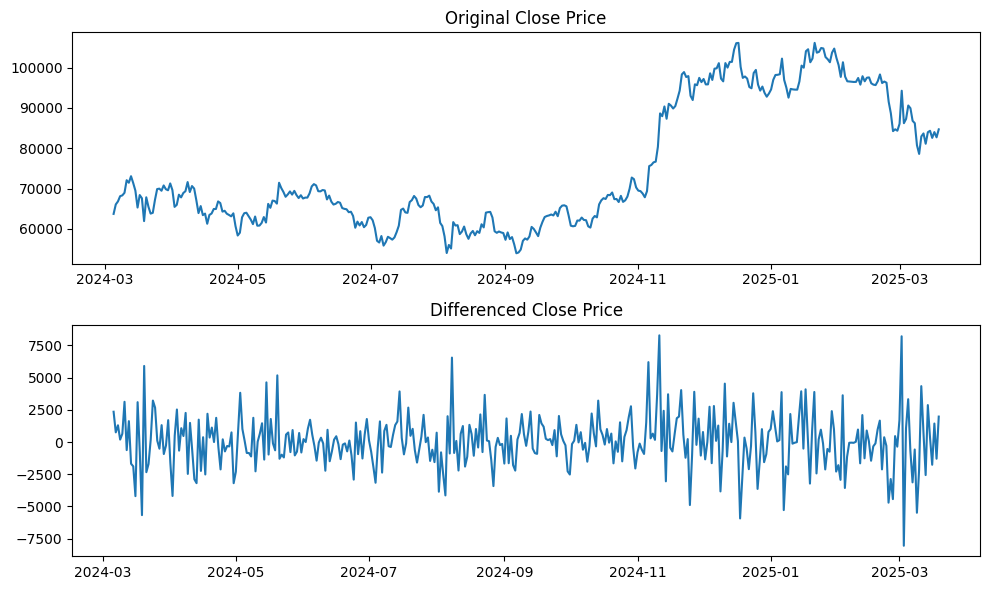

In [24]:
# Plot original data and differenced data
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(arima_df['close'])
plt.title('Original Close Price')

plt.subplot(2, 1, 2)
plt.plot(arima_df['close_diff'])
plt.title('Differenced Close Price')
plt.tight_layout()
plt.show()


In [ ]:
arima_df.reset_index(inplace=True)
# drop index column

print(arima_df.head())

   index  timestamp     close       SMA       EMA        RSI      MACD  \
0      0 2024-03-05  63724.01 -0.513488 -0.456481  77.822116  0.078483   
1      1 2024-03-06  66074.04 -0.513488 -0.456481  77.822116  0.078483   
2      2 2024-03-07  66823.17 -0.513488 -0.456481  77.822116  0.078483   
3      3 2024-03-08  68124.19 -0.513488 -0.456481  77.822116  0.078483   
4      4 2024-03-09  68313.27 -0.513488 -0.456481  77.822116  0.078483   

   MACD_signal   MACD_hist       OBV  ...  middle_band    lower_band  \
0  1008.875495 -145.010934  0.777210  ...   66980.6605  59842.735774   
1  1008.875495 -145.010934  1.141570  ...   66980.6605  59842.735774   
2  1008.875495 -145.010934  1.387102  ...   66980.6605  59842.735774   
3  1008.875495 -145.010934  1.730745  ...   66980.6605  59842.735774   
4  1008.875495 -145.010934  1.822706  ...   66980.6605  59842.735774   

        BBW     lag_1     lag_2     lag_3     lag_4     lag_5  weighted_avg  \
0  0.213134  68245.71  63113.97  61987.28  

In [27]:
arima_df.drop(columns=['index'], inplace=True)
print(arima_df.head())

   timestamp     close       SMA       EMA        RSI      MACD  MACD_signal  \
0 2024-03-05  63724.01 -0.513488 -0.456481  77.822116  0.078483  1008.875495   
1 2024-03-06  66074.04 -0.513488 -0.456481  77.822116  0.078483  1008.875495   
2 2024-03-07  66823.17 -0.513488 -0.456481  77.822116  0.078483  1008.875495   
3 2024-03-08  68124.19 -0.513488 -0.456481  77.822116  0.078483  1008.875495   
4 2024-03-09  68313.27 -0.513488 -0.456481  77.822116  0.078483  1008.875495   

    MACD_hist       OBV        MFI  ...  middle_band    lower_band       BBW  \
0 -145.010934  0.777210  80.743988  ...   66980.6605  59842.735774  0.213134   
1 -145.010934  1.141570  80.743988  ...   66980.6605  59842.735774  0.213134   
2 -145.010934  1.387102  80.743988  ...   66980.6605  59842.735774  0.213134   
3 -145.010934  1.730745  80.743988  ...   66980.6605  59842.735774  0.213134   
4 -145.010934  1.822706  80.743988  ...   66980.6605  59842.735774  0.213134   

      lag_1     lag_2     lag_3     la

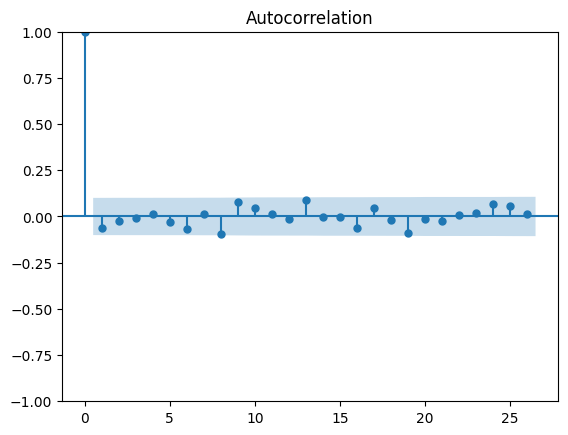

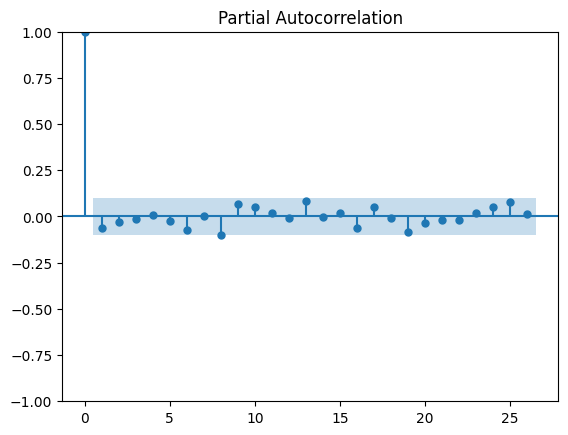

In [28]:
# Plot ACF and PACF for determining p and q
plot_acf(arima_df['close_diff'].dropna())  # ACF plot
plot_pacf(arima_df['close_diff'].dropna())  # PACF plot
plt.show()


In [29]:
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

# Fit ARIMA model (p=1, d=1, q=1)
model = ARIMA(arima_df['close'], order=(1, 1, 1))  # (p, d, q)
fitted_model = model.fit()

# Print model summary
print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  380
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3426.834
Date:                Thu, 20 Mar 2025   AIC                           6859.668
Time:                        00:31:07   BIC                           6871.480
Sample:                             0   HQIC                          6864.356
                                - 380                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7085      1.311      0.540      0.589      -1.861       3.278
ma.L1         -0.7008      1.320     -0.531      0.595      -3.288       1.886
sigma2      4.184e+06   2.15e+05     19.474      0.0

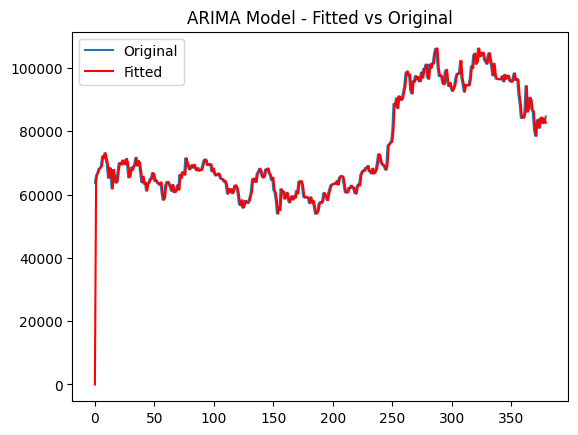

In [30]:
# Plot the forecasted values along with the original series
plt.plot(arima_df['close'], label='Original')
plt.plot(fitted_model.fittedvalues, color='red', label='Fitted')
plt.legend()
plt.title("ARIMA Model - Fitted vs Original")
plt.show()


In [31]:
# Forecast the next 10 periods (e.g., days)
forecast = fitted_model.forecast(steps=10)

# Print the forecasted values
print(forecast)


380    84700.285519
381    84708.217584
382    84713.837480
383    84717.819195
384    84720.640255
385    84722.638985
386    84724.055093
387    84725.058410
388    84725.769264
389    84726.272906
Name: predicted_mean, dtype: float64


### Evaluation

In [ ]:
# Buy & Hold strategy
test_data['Buy_Hold_Returns'] = test_data['Close'].pct_change()
test_data['Cumulative_Buy_Hold_Returns'] = (1 + test_data['Buy_Hold_Returns']).cumprod()

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(test_data['Cumulative_Strategy_Returns'], label='Trading Strategy')
plt.plot(test_data['Cumulative_Buy_Hold_Returns'], label='Buy & Hold')
plt.legend()
plt.show()